# –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è –ö-–°—Ä–µ–¥–Ω–∏—Ö - K-Means Clustering


–†–∞—Å—Å–º–æ—Ç—Ä–∏–º –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—é –¥–∞–Ω–Ω—ã—Ö - —ç—Ç–æ –ø—Ä–∏–º–µ—Ä –æ–±—É—á–µ–Ω–∏—è –±–µ–∑ —É—á–∏—Ç–µ–ª—è (unsupervised learning).

## –¶–µ–ª—å:

–†–∞–±–æ—Ç–∞—è —Å –º–µ—Ç–æ–¥–∞–º–∏ –æ–±—É—á–µ–Ω–∏—è –±–µ–∑ —É—á–∏—Ç–µ–ª—è (unsupervised learning), –æ—á–µ–Ω—å –≤–∞–∂–Ω–æ —É–¥–µ–ª–∏—Ç—å –≤—Ä–µ–º—è –Ω–∞ –ø–æ—Å—Ç–∞–Ω–æ–≤–∫—É –∑–∞–¥–∞—á–∏. –í –Ω–∞—à–µ–º –ø—Ä–∏–º–µ—Ä–µ –º—ã –ø–æ—Å—Ç–∞—Ä–∞–µ–º—Å—è –æ–±—ä–µ–¥–∏–Ω–∏—Ç—å –≤ –∫–ª–∞—Å—Ç–µ—Ä—ã –∫–ª–∏–µ–Ω—Ç–æ–≤ –Ω–µ–∫–æ—Ç–æ—Ä–æ–≥–æ –±–∞–Ω–∫–∞, –¥–ª—è –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤—ã—Ö —Ü–µ–ª–µ–π. –¢–∞–∫–æ–µ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –≤ –∫–ª–∞—Å—Ç–µ—Ä—ã **–æ—á–µ–Ω—å —Å–∏–ª—å–Ω–æ** –∑–∞–≤–∏—Å–∏—Ç –æ—Ç –ø—Ä–µ–¥–º–µ—Ç–Ω–æ–π –æ–±–ª–∞—Å—Ç–∏, –≤ –Ω–∞—à–µ–º —Å–ª—É—á–∞–µ —ç—Ç–æ –º–∞—Ä–∫–µ—Ç–∏–Ω–≥ –≤ –±–∞–Ω–∫–æ–≤—Å–∫–æ–π —Å—Ñ–µ—Ä–µ.

----

## Imports

In [1]:
import json
import math
import re
import time
from datetime import datetime
from string import punctuation, whitespace

import emoji
import numpy as np
import pandas as pd
from natasha import (PER, Doc, MorphVocab, NamesExtractor, NewsEmbedding,
                     NewsMorphTagger, NewsNERTagger, NewsSyntaxParser,
                     Segmenter)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import ast

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from IPython.display import display


def find_bool_cols(df):
    temp_df_max = pd.DataFrame(df.max())
    cols_max = temp_df_max[temp_df_max == 1].dropna().T.columns
    temp_df_min = pd.DataFrame(df.min())
    cols_min = temp_df_min[temp_df_min == 0].dropna().T.columns
    return cols_min.intersection(cols_max)


def get_one_hot(column_name: str, dframe: pd.DataFrame):
    one_hot = pd.get_dummies(dframe[column_name], prefix=column_name)
    dframe = dframe.drop(column_name, axis=1)
    dframe = dframe.join(one_hot)
    return dframe


def display_cluster_corrs(df, cluser_count):
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    clutser_column_name = "Cluster" + str(cluser_count)
    df_temp_corr = get_one_hot(clutser_column_name, df)
    # df_temp_corr = df_temp_corr.drop("Cluster4", axis=1)
    cluster_one_hot_cols = [
        col for col in df_temp_corr.columns if clutser_column_name + "_" in col
    ]
    corrs = df_temp_corr.corr()[cluster_one_hot_cols]
    corrs = corrs.drop([col for col in corrs.index if "Cluster" in col], axis=0)
    for col in cluster_one_hot_cols:
        display(
            pd.DataFrame(corrs[col])
            .sort_values(by=[col], key=lambda x: abs(x), ascending=False)
            .T
        )
    pd.options.display.max_columns = 10
    pd.options.display.max_rows = 10


def display_clusters(df, cluser_count, show_means=True):
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    rows = []
    try:
        for cl in df["Cluster" + str(cluser_count)].unique():
            rows.append(df[df["Cluster" + str(cluser_count)] == cl].mean(numeric_only=True))
    except TypeError as e:
        raise TypeError(
            f"Dataframe has no column named {'Cluster' + str(cluser_count)}"
        ) from e

    df_cluster_means = pd.DataFrame(rows)
    df_cluster_means = df_cluster_means[
        df_cluster_means.columns.drop(list(df.filter(regex=r"Cluster\d+")))
    ]

    # display(pd.DataFrame(df_cluster_means.std().sort_values(ascending=False)).T)
    # display(pd.DataFrame(df_cluster_means.mean().sort_values(ascending=False)).T)

    temp_mean = df_cluster_means.mean()
    cols = pd.DataFrame(temp_mean).T.columns.intersection(find_bool_cols(df))
    temp_mean[cols] = 1

    df_std = (
        pd.DataFrame(df_cluster_means.std() / temp_mean)
        .sort_values(by=[0], ascending=False)
        .T
    )
    print(f"-----------------------{cluser_count}------------------------")
    display(df_std)
    if show_means:
        display(df_cluster_means[df_std.columns])
    # pd.options.display.max_columns = 10
    pd.options.display.max_rows = 10
    
    return df_cluster_means[df_std.columns]

## –ò—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö (EDA - Exploratory Data Analysis)

In [4]:
stopwords_ru = stopwords.words("russian")
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

In [5]:
df = pd.read_csv("../data/for_clustering.csv")
temp_keys = list(df.columns[7:])
temp_vals = ["".join([w[:3] if w[0] in "sn" else w[0] for w in x.split("_")]) for x in list(df.columns[7:])]
d = dict(zip(temp_keys, temp_vals))
df = df.rename(d, axis=1)

In [6]:
def reorder_df(df):
    return df[["pft","pt",
    "neuft","neut",
    "negft","negt",
    "skift","skit",
    "speft","spet",]]

In [7]:
df = df[[
    "text","full_text","rels","poses","lemmas","raw",
    "pft","pt",
    "neuft","neut",
    "negft","negt",
    "skift","skit",
    "speft","spet",
]]

In [8]:
df.head()

text  \
0                        –ü–ª–∞—Å—Ç–∏–∫ –ø—Ä–æ—á–Ω—ã–π   
1                    –µ—Å—Ç—å —Å—ä—ë–º–Ω—ã–π –ø–æ–¥–¥–æ–Ω   
2                      –∏–¥–µ–∞–ª—å–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã   
3                   –∫—Ä–∞—Å–∏–≤—ã–π –≤–Ω–µ—à–Ω–∏–π –≤–∏–¥   
4  –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É –∑–∞ –ø–æ–¥–∞—Ä–æ–∫   

                                           full_text  \
0  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   
1  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   
2  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   
3  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   
4  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   

                                       rels  \
0                         ['nsubj', 'root']   
1                 ['root', 'amod', 'nsubj']   
2                          ['amod', 'conj']   
3                  ['amod', 'amod', 'conj']   
4  ['amod', 'root', 'iobj', 'case', 'nmod']   

                                    poses  \
0                         ['NOUN', 'ADJ']   
1                 ['VERB', 'ADJ', 'NOUN']   
2                         ['ADJ', 'NOUN']   
3                  ['ADJ', 'ADJ', 'NOUN']   
4  ['ADJ', 'NOUN', 'NOUN', 'ADP', 'NOUN']   

                                              lemmas  \
0                             ['–ø–ª–∞—Å—Ç–∏–∫', '–ø—Ä–æ—á–Ω—ã–π']   
1                      ['–±—ã—Ç—å', '—Å—ä–µ–º–Ω—ã–π', '–ø–æ–¥–¥–æ–Ω']   
2                            ['–∏–¥–µ–∞–ª—å–Ω—ã–π', '—Ä–∞–∑–º–µ—Ä']   
3                     ['–∫—Ä–∞—Å–∏–≤—ã–π', '–≤–Ω–µ—à–Ω–∏–π', '–≤–∏–¥']   
4  ['–æ—Ç–¥–µ–ª—å–Ω—ã–π', '—Å–ø–∞—Å–∏–±–æ', '–ø—Ä–æ–¥–∞–≤–µ—Ü', '–∑–∞', '–ø–æ...   

                                                 raw   pft    pt  neuft  neut  \
0  [('–ø–ª–∞—Å—Ç–∏–∫', 'NOUN', 'nsubj'), ('–ø—Ä–æ—á–Ω—ã–π', 'AD...  0.21  0.02   0.14  0.09   
1  [('–±—ã—Ç—å', 'VERB', 'root'), ('—Å—ä–µ–º–Ω—ã–π', 'ADJ', ...  0.21  0.01   0.14  0.89   
2  [('–∏–¥–µ–∞–ª—å–Ω—ã–π', 'ADJ', 'amod'), ('—Ä–∞–∑–º–µ—Ä', 'NOU...  0.21  0.01   0.14  0.99   
3  [('–∫—Ä–∞—Å–∏–≤—ã–π', 'ADJ', 'amod'), ('–≤–Ω–µ—à–Ω–∏–π', 'ADJ...  0.21  0.31   0.14  0.73   
4  [('–æ—Ç–¥–µ–ª—å–Ω—ã–π', 'ADJ', 'amod'), ('—Å–ø–∞—Å–∏–±–æ', 'NO...  0.21  0.01   0.14  0.13   

   negft  negt  skift  skit  speft  spet  
0   0.08  0.02    0.1  0.09   0.04  0.00  
1   0.08  0.01    0.1  0.03   0.04  0.00  
2   0.08  0.09    0.1  0.00   0.04  0.00  
3   0.08  0.00    0.1  0.07   0.04  0.00  
4   0.08  0.00    0.1  0.01   0.04  0.73

In [9]:
df.columns

Index(['text', 'full_text', 'rels', 'poses', 'lemmas', 'raw', 'pft', 'pt',
       'neuft', 'neut', 'negft', 'negt', 'skift', 'skit', 'speft', 'spet'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4219 entries, 0 to 4218
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       4219 non-null   object 
 1   full_text  4219 non-null   object 
 2   rels       4219 non-null   object 
 3   poses      4219 non-null   object 
 4   lemmas     4219 non-null   object 
 5   raw        4219 non-null   object 
 6   pft        4219 non-null   float64
 7   pt         4219 non-null   float64
 8   neuft      4219 non-null   float64
 9   neut       4219 non-null   float64
 10  negft      4219 non-null   float64
 11  negt       4219 non-null   float64
 12  skift      4219 non-null   float64
 13  skit       4219 non-null   float64
 14  speft      4219 non-null   float64
 15  spet       4219 non-null   float64
dtypes: float64(10), object(6)
memory usage: 527.5+ KB


In [11]:
df.describe()

pft           pt        neuft         neut        negft  \
count  4219.000000  4219.000000  4219.000000  4219.000000  4219.000000   
mean      0.263261     0.223781     0.283496     0.508959     0.179438   
std       0.209145     0.291355     0.210952     0.340906     0.123729   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.110000     0.020000     0.115000     0.170000     0.090000   
50%       0.200000     0.080000     0.240000     0.530000     0.160000   
75%       0.360000     0.310000     0.420000     0.840000     0.240000   
max       1.000000     1.000000     1.000000     1.000000     0.890000   

              negt        skift         skit        speft         spet  
count  4219.000000  4219.000000  4219.000000  4219.000000  4219.000000  
mean      0.112143     0.107722     0.069801     0.041235     0.032486  
std       0.150487     0.064274     0.095468     0.101508     0.147684  
min       0.000000     0.010000     0.000000     0.000000     0.000000  
25%       0.020000     0.060000     0.010000     0.000000     0.000000  
50%       0.060000     0.100000     0.040000     0.010000     0.000000  
75%       0.140000     0.140000     0.090000     0.030000     0.000000  
max       0.990000     0.490000     0.930000     0.990000     1.000000

## –£–¥–∞–ª—è–µ–º –ø—É—Ç–∞—é—â–∏–µ –∫–æ–ª–æ–Ω–∫–∏

## –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö

### –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö

**–ù–∞–ø–æ–º–∏–Ω–∞–Ω–∏–µ –ø–æ –ø–æ–≤–æ–¥—É –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ –æ–±—É—á–µ–Ω–∏—è –±–µ–∑ —É—á–∏—Ç–µ–ª—è (unsupervised learning): –Ω–µ –Ω—É–∂–Ω–æ –≤—ã–ø–æ–ª–Ω—è—Ç—å —Ä–∞–∑–±–∏–µ–Ω–∏–µ –Ω–∞ –æ–±—É—á–∞—é—â–∏–π –∏ —Ç–µ—Å—Ç–æ–≤—ã–π –Ω–∞–±–æ—Ä—ã –¥–∞–Ω–Ω—ã—Ö! –ü–æ—Ç–æ–º—É —á—Ç–æ –Ω–µ—Ç —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π, –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è —Å –∫–æ—Ç–æ—Ä–æ–π –ø—Ä–∏–≥–æ–¥–∏–ª—Å—è –±—ã —Ç–µ—Å—Ç–æ–≤—ã–π –Ω–∞–±–æ—Ä –¥–∞–Ω–Ω—ã—Ö!**

–û–¥–Ω–∞–∫–æ –Ω–∞–º –ø–æ-–ø—Ä–µ–∂–Ω–µ–º—É –Ω—É–∂–Ω–æ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞—Ç—å –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –≤ —á–∏—Å–ª–æ–≤—ã–µ - —Ç–∞–º, –≥–¥–µ —ç—Ç–æ –∏–º–µ–µ—Ç —Å–º—ã—Å–ª. –ê —Ç–∞–∫–∂–µ –Ω—É–∂–Ω–æ –≤—ã–ø–æ–ª–Ω–∏—Ç—å –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö, –ø–æ—Ç–æ–º—É —á—Ç–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –º–µ–∂–¥—É —Ç–æ—á–∫–∞–º–∏ —è–≤–ª—è–µ—Ç—Å—è –≤–∞–∂–Ω–æ–π —á–∞—Å—Ç—å—é –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏.

In [12]:
df.head()

text  \
0                        –ü–ª–∞—Å—Ç–∏–∫ –ø—Ä–æ—á–Ω—ã–π   
1                    –µ—Å—Ç—å —Å—ä—ë–º–Ω—ã–π –ø–æ–¥–¥–æ–Ω   
2                      –∏–¥–µ–∞–ª—å–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã   
3                   –∫—Ä–∞—Å–∏–≤—ã–π –≤–Ω–µ—à–Ω–∏–π –≤–∏–¥   
4  –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É –∑–∞ –ø–æ–¥–∞—Ä–æ–∫   

                                           full_text  \
0  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   
1  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   
2  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   
3  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   
4  –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª...   

                                       rels  \
0                         ['nsubj', 'root']   
1                 ['root', 'amod', 'nsubj']   
2                          ['amod', 'conj']   
3                  ['amod', 'amod', 'conj']   
4  ['amod', 'root', 'iobj', 'case', 'nmod']   

                                    poses  \
0                         ['NOUN', 'ADJ']   
1                 ['VERB', 'ADJ', 'NOUN']   
2                         ['ADJ', 'NOUN']   
3                  ['ADJ', 'ADJ', 'NOUN']   
4  ['ADJ', 'NOUN', 'NOUN', 'ADP', 'NOUN']   

                                              lemmas  \
0                             ['–ø–ª–∞—Å—Ç–∏–∫', '–ø—Ä–æ—á–Ω—ã–π']   
1                      ['–±—ã—Ç—å', '—Å—ä–µ–º–Ω—ã–π', '–ø–æ–¥–¥–æ–Ω']   
2                            ['–∏–¥–µ–∞–ª—å–Ω—ã–π', '—Ä–∞–∑–º–µ—Ä']   
3                     ['–∫—Ä–∞—Å–∏–≤—ã–π', '–≤–Ω–µ—à–Ω–∏–π', '–≤–∏–¥']   
4  ['–æ—Ç–¥–µ–ª—å–Ω—ã–π', '—Å–ø–∞—Å–∏–±–æ', '–ø—Ä–æ–¥–∞–≤–µ—Ü', '–∑–∞', '–ø–æ...   

                                                 raw   pft    pt  neuft  neut  \
0  [('–ø–ª–∞—Å—Ç–∏–∫', 'NOUN', 'nsubj'), ('–ø—Ä–æ—á–Ω—ã–π', 'AD...  0.21  0.02   0.14  0.09   
1  [('–±—ã—Ç—å', 'VERB', 'root'), ('—Å—ä–µ–º–Ω—ã–π', 'ADJ', ...  0.21  0.01   0.14  0.89   
2  [('–∏–¥–µ–∞–ª—å–Ω—ã–π', 'ADJ', 'amod'), ('—Ä–∞–∑–º–µ—Ä', 'NOU...  0.21  0.01   0.14  0.99   
3  [('–∫—Ä–∞—Å–∏–≤—ã–π', 'ADJ', 'amod'), ('–≤–Ω–µ—à–Ω–∏–π', 'ADJ...  0.21  0.31   0.14  0.73   
4  [('–æ—Ç–¥–µ–ª—å–Ω—ã–π', 'ADJ', 'amod'), ('—Å–ø–∞—Å–∏–±–æ', 'NO...  0.21  0.01   0.14  0.13   

   negft  negt  skift  skit  speft  spet  
0   0.08  0.02    0.1  0.09   0.04  0.00  
1   0.08  0.01    0.1  0.03   0.04  0.00  
2   0.08  0.09    0.1  0.00   0.04  0.00  
3   0.08  0.00    0.1  0.07   0.04  0.00  
4   0.08  0.00    0.1  0.01   0.04  0.73

In [13]:
X = df.select_dtypes(include='number')

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [15]:
from sklearn.cluster import KMeans

## –í—ã–±–∏—Ä–∞–µ–º –∑–Ω–∞—á–µ–Ω–∏–µ K

In [16]:
ssd = []
temp_range = range(2,10)
for k in temp_range:
    
    model = KMeans(n_clusters=k, n_init="auto", random_state=10)
    
    
    model.fit(scaled_X)
    
    # –°—É–º–º–∞ –∫–≤–∞–¥—Ä–∞—Ç–æ–≤ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π –æ—Ç —Ç–æ—á–µ–∫ –¥–æ –±–ª–∏–∂–∞–π—à–∏—Ö —Ü–µ–Ω—Ç—Ä–æ–≤ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤
    # (SSD - Sum of squared distances) 
    ssd.append(model.inertia_)
    print(f"{k} - {model.inertia_}")

2 - 34082.84367923808
3 - 29755.37417575348
4 - 25366.0325533895
5 - 23271.281950182063
6 - 21207.558256039178
7 - 19739.371974958565
8 - 19016.204225080248
9 - 17567.34612855929


Text(0, 0.5, ' Sum of Squared Distances')

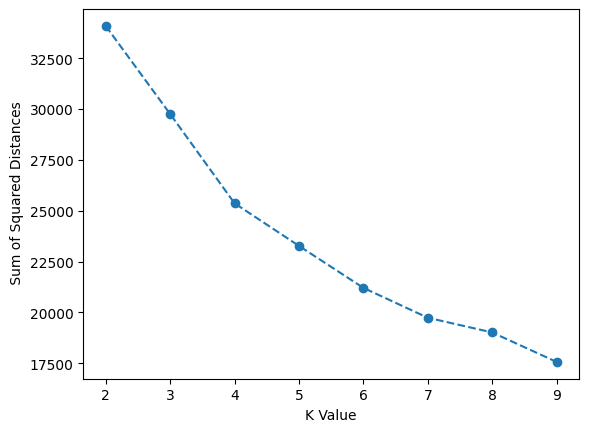

In [17]:
plt.plot(temp_range,ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances")

–ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º **—É–º–µ–Ω—å—à–µ–Ω–∏–µ** –º–µ—Ç—Ä–∏–∫–∏ SSD

In [18]:
ssd

[34082.84367923808,
 29755.37417575348,
 25366.0325533895,
 23271.281950182063,
 21207.558256039178,
 19739.371974958565,
 19016.204225080248,
 17567.34612855929]

In [19]:
# –ò–∑–º–µ–Ω–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫–∏ SSD - —Ç–µ–∫—É—â–µ–µ –º–∏–Ω—É—Å –ø—Ä–µ–¥—ã–¥—É—â–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ! –ò—â–µ–º –≥–¥–µ –∏–∑–º–µ–Ω–µ–Ω–∏–µ –º–µ–Ω—å—à–µ, —á–µ–º –æ—Å—Ç–∞–ª—å–Ω—ã–µ
pd.Series(ssd).diff()

0            NaN
1   -4327.469503
2   -4389.341622
3   -2094.750603
4   -2063.723694
5   -1468.186281
6    -723.167750
7   -1448.858097
dtype: float64

In [20]:
pd.DataFrame(data=zip(temp_range,pd.Series(ssd).diff()),columns=['K','SSD diff'])

K     SSD diff
0  2          NaN
1  3 -4327.469503
2  4 -4389.341622
3  5 -2094.750603
4  6 -2063.723694
5  7 -1468.186281
6  8  -723.167750
7  9 -1448.858097

<Axes: >

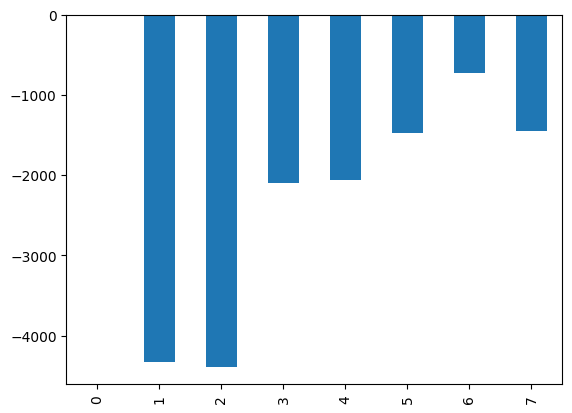

In [21]:
pd.Series(ssd).diff().plot(kind='bar')

In [22]:
from sklearn.metrics import silhouette_score

In [23]:
silhouettes = []
temp_range = range(2, 10)
for k in temp_range:
    model = KMeans(n_clusters=k, n_init="auto", random_state=10)
    model.fit(scaled_X)
    silhouettes.append(silhouette_score(scaled_X,model.labels_))
    print(f"{k} - {silhouette_score(scaled_X,model.labels_)}")

2 - 0.23579908242307482
3 - 0.1973530723824858
4 - 0.2231230779602855
5 - 0.17089912019298947
6 - 0.1843751384631508
7 - 0.18398497035063513
8 - 0.18989305180719845
9 - 0.19364136477686208


In [24]:
clusters_silhoettes = sorted(
    list(zip(temp_range, silhouettes)), key=lambda x: x[1], reverse=True
)
clusters_silhoettes

[(2, 0.23579908242307482),
 (4, 0.2231230779602855),
 (3, 0.1973530723824858),
 (9, 0.19364136477686208),
 (8, 0.18989305180719845),
 (6, 0.1843751384631508),
 (7, 0.18398497035063513),
 (5, 0.17089912019298947)]

For n_clusters = 2 The average silhouette_score is : 0.23579908242307482
For n_clusters = 3 The average silhouette_score is : 0.1973530723824858
For n_clusters = 4 The average silhouette_score is : 0.2231230779602855
For n_clusters = 5 The average silhouette_score is : 0.17089912019298947
For n_clusters = 6 The average silhouette_score is : 0.1843751384631508
For n_clusters = 7 The average silhouette_score is : 0.18398497035063513
For n_clusters = 8 The average silhouette_score is : 0.18989305180719845
For n_clusters = 9 The average silhouette_score is : 0.19364136477686208
[(2, 0.23579908242307482), (4, 0.2231230779602855), (3, 0.1973530723824858), (9, 0.19364136477686208), (8, 0.18989305180719845), (6, 0.1843751384631508), (7, 0.18398497035063513), (5, 0.17089912019298947)]


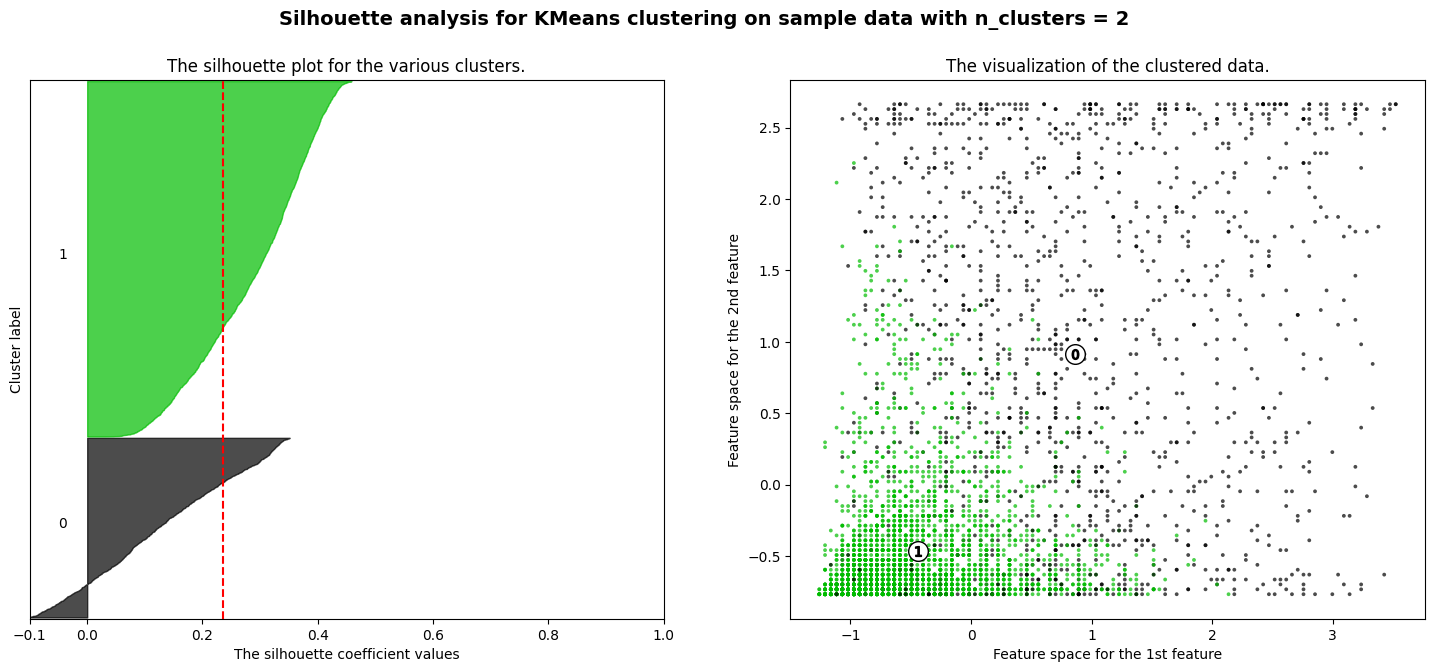

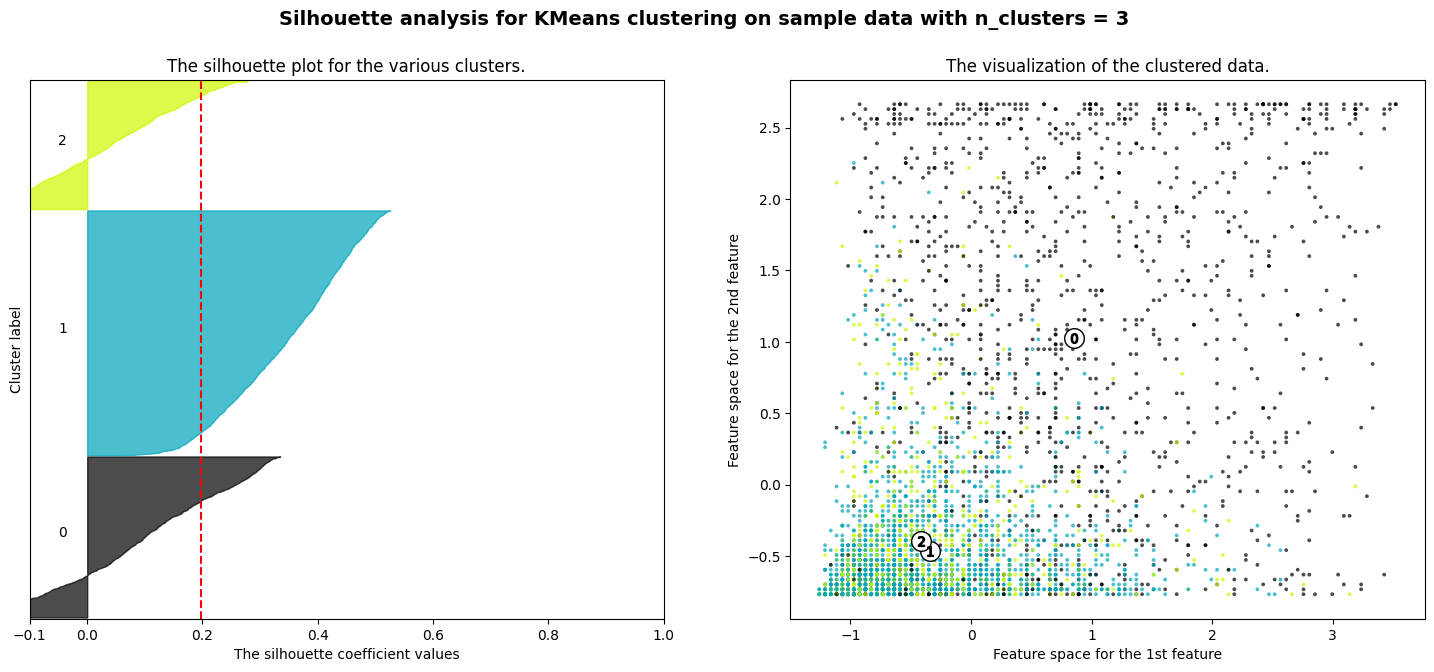

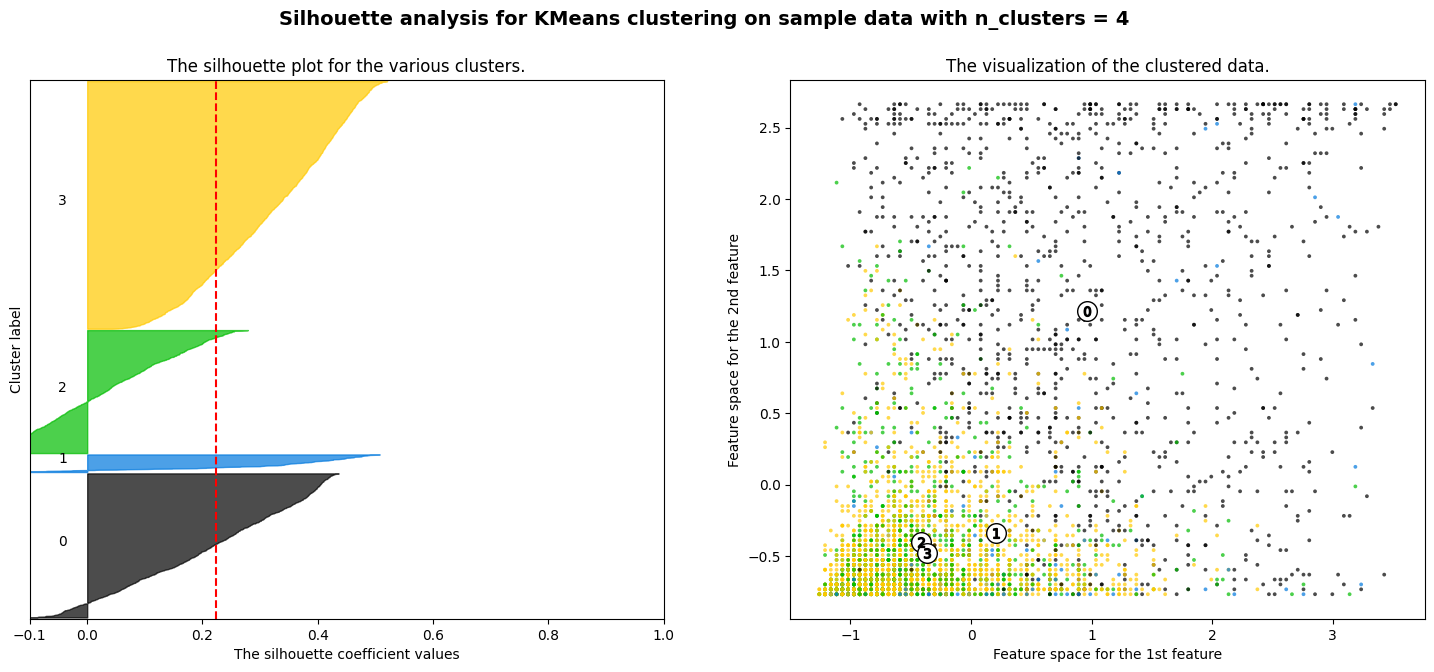

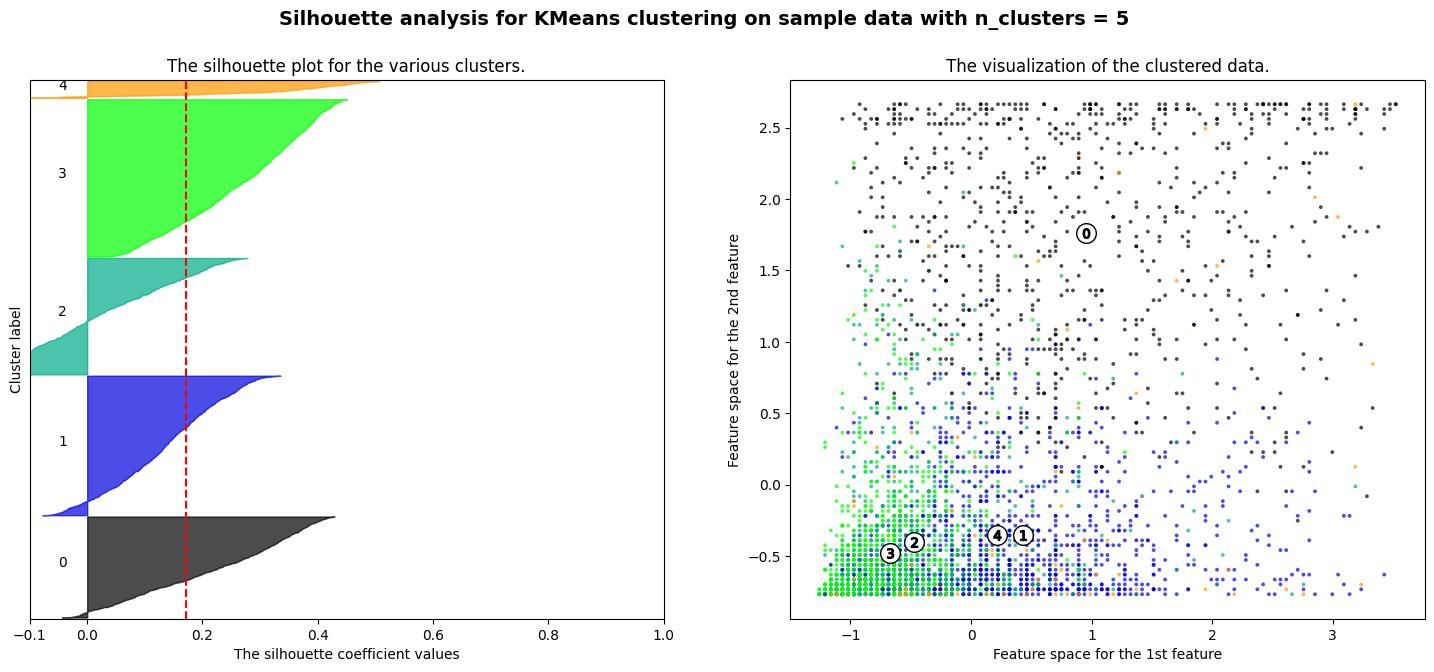

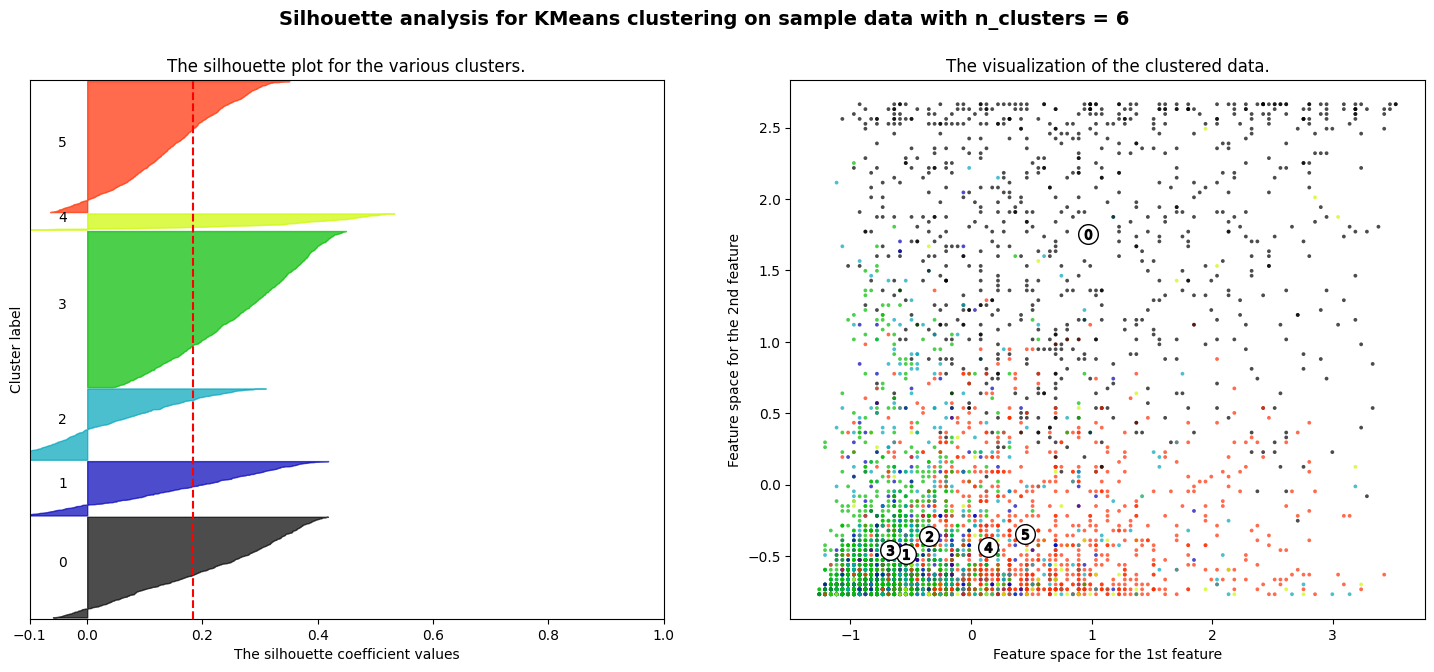

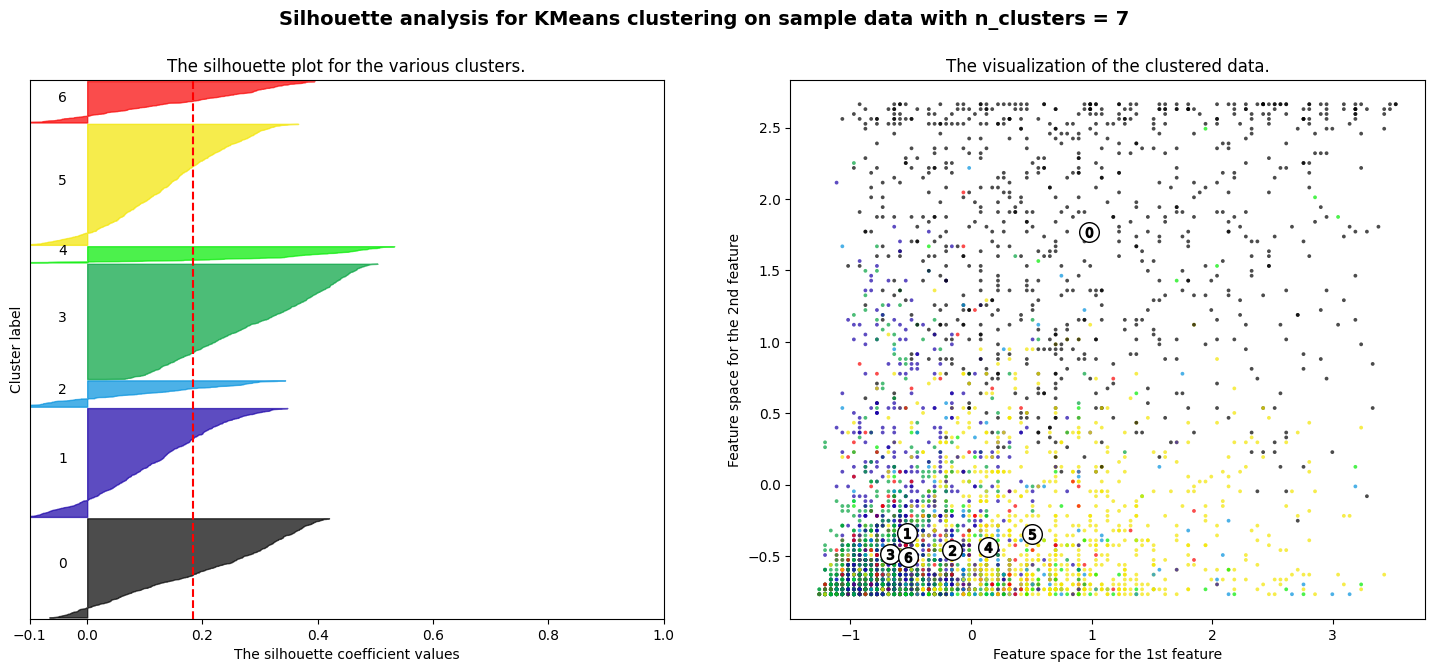

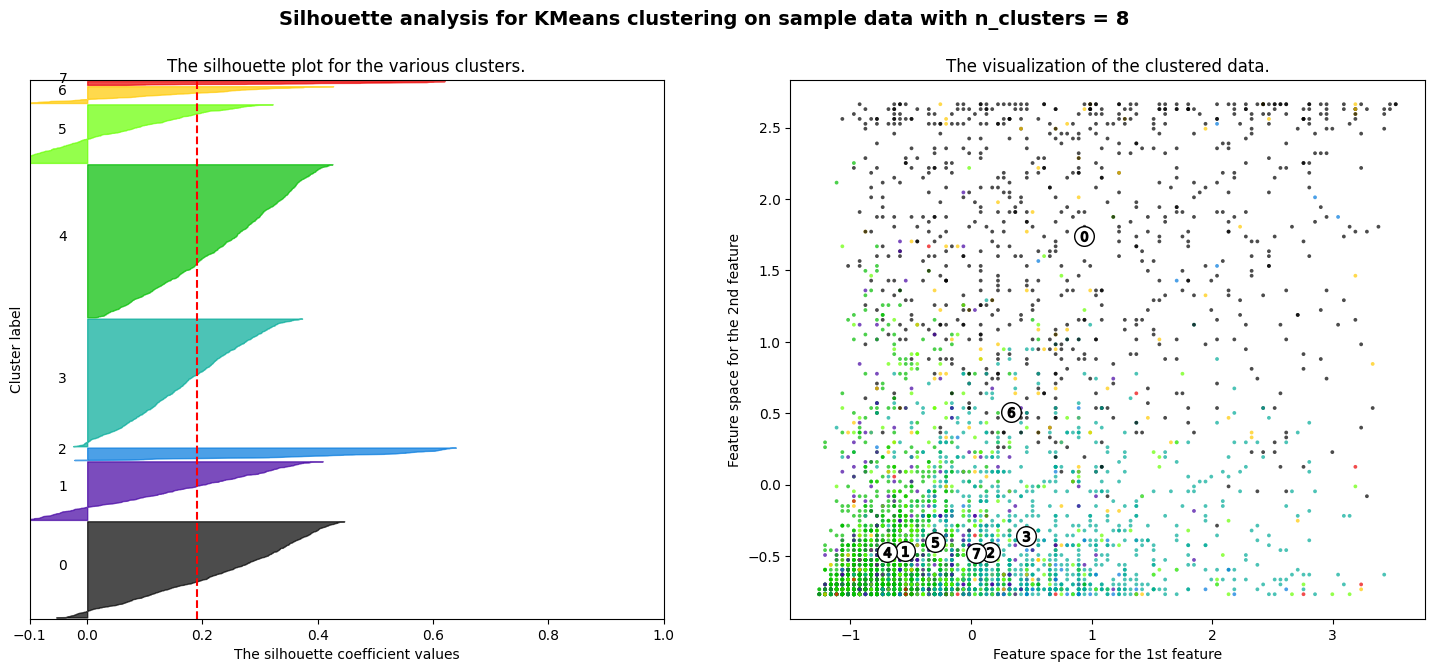

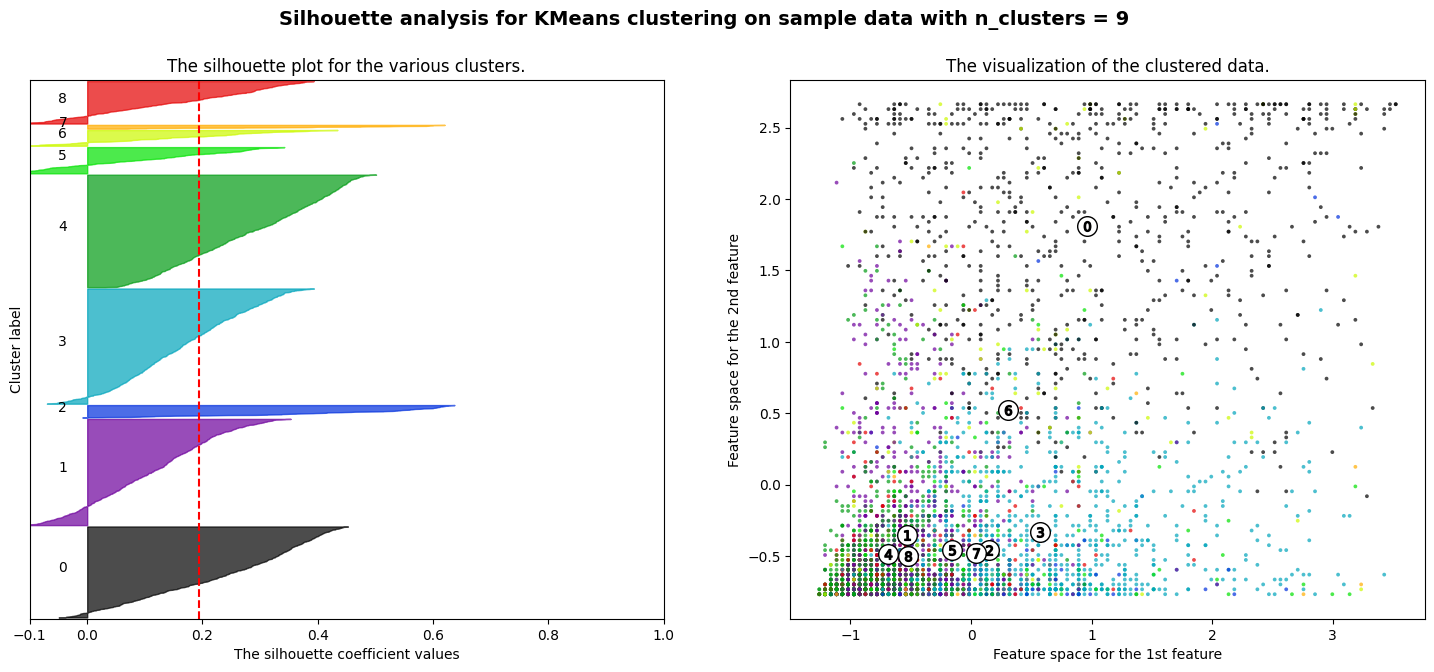

[(2, 0.23579908242307482), (4, 0.2231230779602855), (3, 0.1973530723824858), (9, 0.19364136477686208), (8, 0.18989305180719845), (6, 0.1843751384631508), (7, 0.18398497035063513), (5, 0.17089912019298947)]


In [25]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = scaled_X

score = []

# range_n_clusters = sorted([cluster for cluster, sil in clusters_silhoettes])
# range_n_clusters = [3]

range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    # clusterer = KMeans(n_clusters=n_clusters, n_init="auto")
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    df[f"Cluster{n_clusters}"] = cluster_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    score.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    
clusters_silhoettes = sorted(
    list(zip(temp_range, score)), key=lambda x: x[1], reverse=True
)
print(clusters_silhoettes)

plt.show()
print(clusters_silhoettes)

In [26]:
clusters_silhoettes

[(2, 0.23579908242307482),
 (4, 0.2231230779602855),
 (3, 0.1973530723824858),
 (9, 0.19364136477686208),
 (8, 0.18989305180719845),
 (6, 0.1843751384631508),
 (7, 0.18398497035063513),
 (5, 0.17089912019298947)]

In [40]:
cluster_count = 9

In [41]:
for n in range(2, cluster_count):
    display_clusters(df, n, False)

-----------------------2------------------------


speft      negt     negft      skit      neut     skift        pt  \
0  0.943182  0.566691  0.448733  0.358786  0.301523  0.292689  0.283639   

        pft     neuft      spet  
0  0.192884  0.160692  0.056929

-----------------------3------------------------


speft      negt      skit     negft     skift     neut        pt  \
0  0.977311  0.845219  0.808706  0.504614  0.415759  0.29338  0.245607   

        pft     neuft      spet  
0  0.148833  0.134903  0.050663

-----------------------4------------------------


speft      negt      skit     negft     skift      spet      neut  \
0  1.363174  1.012989  0.837754  0.566913  0.415745  0.376704  0.309587   

        pt    neuft       pft  
0  0.23708  0.13747  0.134645

-----------------------5------------------------


speft      negt     skit     negft     skift     spet      neut  \
0  1.432357  0.951223  0.77669  0.531394  0.392388  0.34357  0.314159   

         pt     neuft       pft  
0  0.281532  0.169154  0.139259

-----------------------6------------------------


speft      negt      skit     negft     skift      spet      neut  \
0  1.439555  1.211808  0.940137  0.541346  0.429946  0.325151  0.282433   

         pt     neuft       pft  
0  0.258917  0.147562  0.132846

-----------------------7------------------------


speft      skit      negt     negft     skift      spet      neut  \
0  1.490215  1.235657  1.204856  0.533788  0.407975  0.301349  0.274138   

         pt     neuft       pft  
0  0.242905  0.154633  0.128366

-----------------------8------------------------


speft      negt      skit     negft     skift      spet      neut  \
0  1.546668  1.232406  0.990662  0.640928  0.446219  0.371831  0.272809   

         pt     neuft       pft  
0  0.232468  0.154837  0.113919

In [42]:
df_means = display_clusters(df, cluster_count, False)

-----------------------9------------------------


speft      negt      skit     negft     skift      spet      neut  \
0  1.624487  1.269458  1.258751  0.624447  0.426359  0.353878  0.270973   

         pt     neuft       pft  
0  0.226527  0.163199  0.115325

In [43]:
reorder_df(df_means)

pft        pt     neuft      neut     negft      negt     skift  \
0  0.382630  0.125390  0.178485  0.638799  0.123669  0.082165  0.076591   
1  0.293960  0.089307  0.120990  0.047723  0.109802  0.015644  0.082277   
2  0.152477  0.120352  0.279988  0.564378  0.259272  0.098462  0.169918   
3  0.327323  0.372441  0.044252  0.295984  0.064961  0.069685  0.066850   
4  0.153284  0.077009  0.270088  0.393109  0.367713  0.496774  0.132815   
5  0.118902  0.082650  0.567550  0.809435  0.161164  0.078337  0.084468   
6  0.465178  0.749466  0.162315  0.124151  0.121781  0.048658  0.082205   
7  0.229668  0.089621  0.244929  0.369716  0.196209  0.125545  0.182607   
8  0.271613  0.083226  0.018065  0.031935  0.047742  0.026452  0.068387   

       skit     speft      spet  
0  0.044870  0.034318  0.009275  
1  0.033267  0.126238  0.805446  
2  0.083134  0.015845  0.008345  
3  0.042992  0.384488  0.042913  
4  0.087566  0.017947  0.004868  
5  0.040377  0.010266  0.002306  
6  0.035192  0.032247  0.006452  
7  0.379005  0.025261  0.003270  
8  0.046452  0.739677  0.820645

# –ò—Å—Å–ª–µ–¥—É–µ–º –∫–æ–Ω–∫—Ä–µ—Ç–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤

In [44]:
cluster_col_name = "Cluster" + str(cluster_count)

## –¢–µ—Å—Ç–∏—Ä—É–µ–º —Ä–∞–∑–±–∏–µ–Ω–∏–µ –Ω–∞ –∫–ª–∞—Å—Ç–µ—Ä—ã

In [45]:
clusterer = KMeans(n_clusters=cluster_count, n_init="auto", random_state=10)
clusterer.fit_predict(scaled_X)

array([3, 3, 3, ..., 4, 4, 4])

In [46]:
df_ohot = get_one_hot(cluster_col_name, df)
df_ohot = df_ohot.drop([col for col in df.columns if "Cluster" in col and cluster_col_name not in col], axis = 1)

In [47]:
df_cluster = df
df_cluster = df_cluster.drop([col for col in df.columns if "Cluster" in col and cluster_col_name not in col], axis = 1)

In [48]:
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

def make_n_gramms(df):
    df_nouns = df
    if type(df_nouns["raw"].iloc[0]) is str:
        df_nouns.loc[:,"raw"] = df_nouns["raw"].apply(ast.literal_eval)
    df_nouns["noun"] = df_nouns["raw"].apply(lambda x: 
        [
            item[0]
            for item in x
            if not (item[0] in stopwords_ru or re.search(rf"\d|[{punctuation}]", item[0]))
            and item[1] == "NOUN"
        ])
    df_nouns = df_nouns.explode("noun")

    df_x = df_nouns.groupby(["noun"])["text"].agg({
        ". ".join,
    })
    df_x.columns = [col[0] for col in df_x.columns]
    # df_x[df_x.columns[0]].agg(len).sort_values(ascending=False)
    df_nouns = pd.DataFrame(df_x[df_x.columns[0]])
    df_nouns["len"] = df_nouns["j"].agg(len)
    df_nouns = df_nouns.sort_values("len", ascending=False)
    def get_counts(corpus):
        try:
            regex = re.compile(r"(\s–Ω–µ)\s", re.IGNORECASE)
            corpus = regex.sub(r"\g<1>", corpus)
            
            doc_corpus = Doc(corpus)
            doc_corpus.segment(segmenter)
            doc_corpus.tag_morph(morph_tagger)
            doc_corpus.parse_syntax(syntax_parser)
            doc_corpus.tag_morph(morph_tagger)
            for token in doc_corpus.tokens:
                token.lemmatize(morph_vocab)
            data_natasha = doc_corpus.tokens
            columns = list(doc_corpus.tokens[0].as_json.keys())
            df_natasha = pd.DataFrame(data=data_natasha, columns=columns)
            
            df_adj = df_natasha[df_natasha["pos"] == "ADJ"]
            if len(df_adj.index) == 0:
                return []
            
            cv = CountVectorizer()   
            cv_fit = cv.fit_transform(df_adj['lemma'])    
            word_list = cv.get_feature_names_out() 
            count_list = cv_fit.toarray().sum(axis=0)
            df_counts = pd.DataFrame.from_dict(zip(word_list,count_list))
            df_counts = df_counts.rename({0: 'token', 1: 'count'}, axis=1)
            df_counts = df_counts.sort_values(["count"], ascending=False)
            df_counts = df_counts[df_counts["count"] > 2]
            
            return df_counts.to_dict('tight')["data"]
        except:
            return []
    noun_lemmas = df_nouns["j"].agg(get_counts)
    return pd.DataFrame(noun_lemmas)

In [49]:
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 25)

In [50]:
df_clusters_counts = [make_n_gramms(df_cluster[df_cluster["Cluster" + str(cluster_count)] == i]) for i in range(cluster_count)]

In [51]:
# pd.reset_option('max_colwidth')

In [58]:
df_cluster_counts

j
noun                                     
–≥–æ—Ä—à–æ–∫                                 []
—Ç–æ–≤–∞—Ä                      [[—É–∂–∞—Å–Ω—ã–π, 3]]
—É–ø–∞–∫–æ–≤–∫–∞   [[–ø–ª–æ—Ö–æ–π, 3], [–ø—Ä–æ–∑—Ä–∞—á–Ω—ã–π, 3]]
–±—Ä–∞–∫                       [[—É–∂–∞—Å–Ω—ã–π, 3]]
–æ—Ç–∑—ã–≤                       [[–ø–ª–æ—Ö–æ–π, 3]]
...                                   ...
–∫–æ–≤—Ä–∏–∫                                 []
—Å–≤–∏–Ω—Å—Ç–≤–æ                               []
—Ü–µ–Ω–∞                                   []
–ø–ª–∞—Å–º–∞—Å—Å–∞                              []
—Å–ª–µ–∑–∞                                  []

[361 rows x 1 columns]

In [74]:
df_cluster_sub = df_cluster[(df_cluster["Cluster" + str(cluster_count)] == 8)]
df_neg_temp = make_n_gramms(df_cluster_sub)
df_neg_res = df_neg_temp[df_neg_temp["j"].agg(len) > 0]
df_neg_res

j
noun                                    
—Ç–æ–≤–∞—Ä                     [[—É–∂–∞—Å–Ω—ã–π, 3]]
—É–ø–∞–∫–æ–≤–∫–∞  [[–ø–ª–æ—Ö–æ–π, 3], [–ø—Ä–æ–∑—Ä–∞—á–Ω—ã–π, 3]]
–±—Ä–∞–∫                      [[—É–∂–∞—Å–Ω—ã–π, 3]]
–æ—Ç–∑—ã–≤                      [[–ø–ª–æ—Ö–æ–π, 3]]
–ø–∞–∫–µ—Ç                     [[–æ–±—ã—á–Ω—ã–π, 3]]
—Ä–∞–∑–º–µ—Ä                    [[–±–æ–ª—å—à–∏–π, 3]]

In [75]:
df_cluster_sub2 = df_cluster[
    (df_cluster["Cluster" + str(cluster_count)] != 2)
    & (df_cluster["Cluster" + str(cluster_count)] != 7)
    & (df_cluster["Cluster" + str(cluster_count)] != 8)
]
df_pos_temp = make_n_gramms(df_cluster_sub2)
df_pos_res = df_pos_temp[df_pos_temp["j"].agg(len) > 0]
df_pos_res

j
noun                                                                                                                                                                                                                                                                                                                                                                                                                      
–≥–æ—Ä—à–æ–∫     [[–∫—Ä–∞—Å–∏–≤—ã–π, 29], [—Ö–æ—Ä–æ—à–∏–π, 20], [–º–∞–ª–µ–Ω—å–∫–∏–π, 15], [–≤–Ω—É—Ç—Ä–µ–Ω–Ω–∏–π, 14], [–æ—Ç–ª–∏—á–Ω—ã–π, 14], [–Ω–µ–±–æ–ª—å—à–æ–π, 10], [–±–æ–ª—å—à–æ–π, 9], [—É–¥–æ–±–Ω—ã–π, 9], [–∫–ª–∞—Å—Å–Ω—ã–π, 8], [—Ü–≤–µ—Ç–æ—á–Ω—ã–π, 8], [–ø—Ä–µ–∫—Ä–∞—Å–Ω—ã–π, 7], [–±–æ–ª—å—à–∏–π, 7], [—Å—Ä–µ–¥–Ω–∏–π, 7], [—Å–∏–º–ø–∞—Ç–∏—á–Ω—ã–π, 6], [–¥—Ä—É–≥–æ–π, 6], [–±–µ–ª—ã–π, 6], [–Ω—É–∂–Ω—ã–π, 6], [—Ä–∞–∑–Ω—ã–π, 6], [–æ–≥—Ä–æ–º–Ω—ã–π, 5], [—Å–∞–º, 5], [—á–µ—Ä–Ω—ã–π, 5], [–≥–æ—Ä—à–æ–∫, 5], [–ø–µ—Ä–≤—ã–π, 4], [—Å–∞–º—ã–π, 4], [–ø—Ä–æ–∑—Ä–∞—á–Ω—ã–π, 4], [–≤—ã—Å–æ–∫–∏–π, 4], [–≤—Ç–æ—Ä–æ–π, 4], [—Ü–µ...
–ª–∞–º–ø–∞      [[—É–¥–æ–±–Ω—ã–π, 18], [—Ö–æ—Ä–æ—à–∏–π, 13], [—Å–∞–º, 13], [–æ—Ç–ª–∏—á–Ω—ã–π, 12], [–ø–æ–ª–Ω—ã–π, 9], [–Ω—É–∂–Ω—ã–π, 9], [–Ω–µ–ø–ª–æ—Ö–æ–π, 9], [–ø–µ—Ä–≤—ã–π, 8], [—Ä–∞–±–æ—á–∏–π, 8], [–¥–æ–≤–æ–ª—å–Ω—ã–π, 8], [–∫–ª–∞—Å—Å–Ω—ã–π, 8], [–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 7], [–∑–∞–º–µ—á–∞—Ç–µ–ª—å–Ω—ã–π, 7], [–∫—Ä–µ–ø–∫–∏–π, 6], [–¥—Ä—É–≥–æ–π, 6], [–≤—Ç–æ—Ä–æ–π, 6], [–∫—Ä–∞—Å–Ω—ã–π, 5], [—Ä–∞–∑–Ω—ã–π, 5], [—Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π, 5], [–¥–∞–Ω–Ω—ã–π, 4], [—Å–∏–Ω–∏–π, 4], [–±–æ–ª—å—à–∏–π, 4], [–ø—Ä–∏—è—Ç–Ω—ã–π, 4], [–ª–∞–º–ø–∞, 3], [–ª–∞–±–æ—Ä–∞—Ç–æ—Ä–Ω—ã–π, 3], [—Ä–æ–∑–æ–≤—ã–π, 3], [–Ω–µ–±–æ–ª—å—à–æ–π, 3], ...
—Ü–≤–µ—Ç       [[–±–µ–ª—ã–π, 27], [–∫—Ä–∞—Å–∏–≤—ã–π, 14], [–¥—Ä—É–≥–æ–π, 12], [–ø—Ä–∏—è—Ç–Ω—ã–π, 10], [—á–µ—Ä–Ω—ã–π, 9], [–º–∞–ª–µ–Ω—å–∫–∏–π, 8], [—Ä–∞–∑–Ω—ã–π, 8], [–æ—Ç–ª–∏—á–Ω—ã–π, 8], [–Ω–µ–±–æ–ª—å—à–æ–π, 8], [—Å–µ—Ä—ã–π, 7], [—Ö–æ—Ä–æ—à–∏–π, 7], [—É–¥–æ–±–Ω—ã–π, 6], [—Ä–æ–∑–æ–≤—ã–π, 6], [–º–æ–ª–æ—á–Ω—ã–π, 5], [—Å–∏—Ä–µ–Ω–µ–≤—ã–π, 5], [—è—Ä–∫–∏–π, 5], [—Å–∞–º, 4], [—Å–∞–º—ã–π, 4], [–ø—Ä–æ—á–Ω—ã–π, 4], [—Å–∏–º–ø–∞—Ç–∏—á–Ω—ã–π, 4], [–∫–æ–º–Ω–∞—Ç–Ω—ã–π, 4], [—Ü–µ–ª—ã–π, 4], [–Ω—É–∂–Ω—ã–π, 3], [–º—è–≥–∫–∏–π, 3], [–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 3], [–¥–æ–≤–æ–ª—å–Ω—ã–π, 3], [–∫—Ä–∞—Å–Ω—ã–π, 3], [–≤—ã—Å–æ–∫–∏–π,...
—Ç–æ–≤–∞—Ä                                                                                                                                                                                                             [[–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 19], [–¥–æ–≤–æ–ª—å–Ω—ã–π, 14], [–¥–∞–Ω–Ω—ã–π, 9], [—Ü–µ–ª—ã–π, 7], [—Ö–æ—Ä–æ—à–∏–π, 5], [–±—Ä–∞–∫–æ–≤–∞—Ç—å, 5], [–Ω—É–∂–Ω—ã–π, 4], [–ø–æ–ª–Ω—ã–π, 4], [—Å–∞–º, 4], [–¥–æ–ª–∂–Ω—ã–π, 3], [–Ω–æ—Ä–º–∞–ª—å–Ω—ã–π, 3], [–º–µ–ª–∫–∏–π, 3], [–æ–±–∏–¥–Ω—ã–π, 3], [–±–æ–ª—å—à–æ–π, 3]]
–ø—Ä–æ–¥–∞–≤–µ—Ü                                                                                                                                                                                                                                                                                           [[–ø—Ä–∏—è—Ç–Ω—ã–π, 4], [–±–æ–ª—å—à–æ–π, 4], [–±—ã—Å—Ç—Ä—ã–π, 4], [–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 4], [–¥—Ä—É–≥–æ–π, 4], [–º–∞–ª–µ–Ω—å–∫–∏–π, 3], [–∫—Ä–∞—Å–∏–≤—ã–π, 3], [–ø–æ–ª–Ω—ã–π, 3]]
...                                                                                                                                                                                                                                                                                                                                                                                                                    ...
–æ—Ç—Ç–µ–Ω–æ–∫                                                                                                                                                                                                                                                                                                                           

In [78]:
df_neg_res.to_csv("../data/data_negative.csv")

In [79]:
df_pos_res.to_csv("../data/data_positive.csv")

In [ ]:
indexer = 1
df_neg = None
for df_cluster_counts in df_clusters_counts:
    if indexer in [3,8]:
        continue
    if indexer == 9:
        df_neg = df_cluster_counts[df_cluster_counts["j"].agg(len) > 0]
        continue
    
    df_cluster[df_cluster["Cluster" + str(cluster_count)] == indexer-1]
    display(df_cluster_counts[df_cluster_counts["j"].agg(len) > 0])
    indexer += 1

In [70]:
indexer = 1
for df_cluster_counts in df_clusters_counts:
    print(f"-----------------------{indexer}------------------------")
    display(df_cluster[df_cluster["Cluster" + str(cluster_count)] == indexer-1])
    display(df_cluster_counts[df_cluster_counts["j"].agg(len) > 0])
    indexer += 1

-----------------------1------------------------


text  \
22                                                                  –û—Ç–ª–∏—á–Ω—ã–µ —è—â–∏–∫–∏ –æ—á–µ–Ω—å –¥–æ–≤–æ–ª—å–Ω–∞   
25                                                                –ë–ª–∞–≥–æ–¥–∞—Ä—é –∑–∞ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π —Ç–æ–≤–∞—Ä   
28                                                         –û —ç—Ç–æ –æ—á–µ–Ω—å –∫–ª–∞—Å—Å–Ω—ã–µ —É–¥–æ–±–Ω—ã–µ –∫—Ä–µ–ø–ª–µ–Ω–∏—è   
30                                      –•–æ—Ä–æ—à–∏–π –¥–µ—Ä–∂–∞—Ç–µ–ª—å –º–æ–∂–Ω–æ –ø–æ–¥–æ–≥–Ω–∞—Ç—å –ø–æ–¥ —Ä–∞–∑–Ω—É—é —à–∏—Ä–∏–Ω—É –ø–µ—Ä–∏–ª   
31                                                                   –∫–æ–Ω—Å—Ç—Ä—É–∫—Ü–∏—è –¥–æ–≤–æ–ª—å–Ω–æ –∫—Ä–µ–ø–∫–∞—è   
...                                                                                           ...   
4178                                                                          –û—á–µ–Ω—å —É–¥–æ–±–Ω–∞—è –ª–∞–º–ø–∞   
4181                                                     –•–æ—Ä–æ—à–∞—è –ª–∞–º–ø–∞ —Ä–∞–±–æ—Ç–∞–µ—Ç —Ö–æ—Ä–æ—à–æ —Å–∏–Ω–∏–π —Å–≤–µ—Ç   
4192                                                                            —É–¥–æ–±–Ω—ã–π –¥–µ—Ä–∂–∞—Ç–µ–ª—å   
4195  –û—á–µ–Ω—å –∫—Ä–∞—Å–∏–≤–∞—è –ª–∞–º–ø–∞ üí°üòç —Ä–∞–±–æ—Ç–∞–µ—Ç –Ω–∞ –ø—É–Ω–∫—Ç–µ –≤—ã–¥–∞—á–∏ –ü–æ–∫—É–ø–∞–ª–∞ –¥–ª—è –ª—é–±–∏–º—ã—Ö —Ä–∞—Å—Ç–µ–Ω–∏–π –µ—â—ë —Å—Ç–∏–ª—å–Ω–æ   
4198                                                                   –≠—Ç–æ —Å–∞–º–∞—è –º–æ—â–Ω–∞—è —Ñ–∏—Ç–æ–ª–∞–º–ø–∞   

                                                                                                                                                                                                                 full_text  \
22                                                                    –û—Ç–ª–∏—á–Ω—ã–µ —è—â–∏–∫–∏, –∫—É–ø–∏–ª–∞ 4 —à—Ç, –æ—á–µ–Ω—å –¥–æ–≤–æ–ª—å–Ω–∞.  –ù–∞ —à–∏—Ä–æ–∫—É—é —Å—Ç–µ–Ω–∫—É –∏—Å–∫–∞–ª–∞. –ì–∞–π–∫–∏ –Ω–∞–¥–æ –∑–∞—Ç—è–≥–∏–≤–∞—Ç—å —Å–∏–ª—å–Ω–æ,  –ø—Ä–∏–¥–µ—Ä–∂–∏–≤–∞—è —Å –æ–±—Ä–∞—Ç–Ω–æ–π —Å—Ç–æ—Ä–æ–Ω—ã –ø–ª–æ—Å–∫–æ–≥—É–±—Ü–∞–º–∏.   
25                                                                           –ö—Ä–µ–ø–ª–µ–Ω–∏–µ –∏–¥–µ–∞–ª—å–Ω–æ –∑–∞–∫—Ä–µ–ø–∏–ª–æ—Å—å –Ω–∞ –ø–µ—Ä–∏–ª–∞—Ö –±–∞–ª–∫–æ–Ω–∞ , —è—â–∏–∫ —Å —Ü–≤–µ—Ç–∞–º–∏ —Ç–∞–∫ –∂–µ –∏–¥–µ–∞–ª—å–Ω–æ –≤–æ—à–µ–ª. –ë–ª–∞–≥–æ–¥–∞—Ä—é –∑–∞ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π —Ç–æ–≤–∞—Ä –∏ –±—ã—Å—Ç—Ä—É—é –¥–æ—Å—Ç–∞–≤–∫—É!   
28                                                                                                                      –û, —ç—Ç–æ –æ—á–µ–Ω—å –∫–ª–∞—Å—Å–Ω—ã–µ —É–¥–æ–±–Ω—ã–µ –∏ –ø—Ä–æ—á–Ω—ã–µ –∫—Ä–µ–ø–ª–µ–Ω–∏—è! –ó–∞–∫–∞–∑–∞–ª–∞ 4 —à—Ç.—Å—Ä–∞–∑—É, –≤—Å–µ –≤ –∏–¥–µ–∞–ª—å–Ω–æ–º —Å–æ—Å—Ç–æ—á–Ω–∏–∏!   
30                                                                      –•–æ—Ä–æ—à–∏–π –¥–µ—Ä–∂–∞—Ç–µ–ª—å, –∫—Ä–µ–ø–ª–µ–Ω–∏–µ –º–æ–∂–Ω–æ –ø–æ–¥–æ–≥–Ω–∞—Ç—å –ø–æ–¥ —Ä–∞–∑–Ω—É—é —à–∏—Ä–∏–Ω—É –ø–µ—Ä–∏–ª. –í—ã–¥–µ—Ä–∂–∞–ª —è—â–∏–∫ —Å –∑–µ–º–ª–µ–π, –∫–æ–Ω—Å—Ç—Ä—É–∫—Ü–∏—è –¥–æ–≤–æ–ª—å–Ω–æ –∫—Ä–µ–ø–∫–∞—è. –†–∞–∑–º–µ—Ä—ã —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—Ç    
31                                                                      –•–æ—Ä–æ—à–∏–π –¥–µ—Ä–∂–∞—Ç–µ–ª—å, –∫—Ä–µ–ø–ª–µ–Ω–∏–µ –º–æ–∂–Ω–æ –ø–æ–¥–æ–≥–Ω–∞—Ç—å –ø–æ–¥ —Ä–∞–∑–Ω—É—é —à–∏—Ä–∏–Ω—É –ø–µ—Ä–∏–ª. –í—ã–¥–µ—Ä–∂–∞–ª —è—â–∏–∫ —Å –∑–µ–º–ª–µ–π, –∫–æ–Ω—Å—Ç—Ä—É–∫—Ü–∏—è –¥–æ–≤–æ–ª—å–Ω–æ –∫—Ä–µ–ø–∫–∞—è. –†–∞–∑–º–µ—Ä—ã —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—Ç    
...                                                                                                                                                                                                                    ...   
4178                                                                                      –û—á–µ–Ω—å —É–¥–æ–±–Ω–∞—è –ª–∞–º–ø–∞. –û—Ö–≤–∞—Ç—ã–≤–∞–µ—Ç –±–æ–ª—å—à–æ–π —Ä–∞–¥–∏—É—Å –æ—Å–≤–µ—â–µ–Ω–∏—è. –¢—Ä–∏ —Ü–≤–µ—Ç–∞ –∞—Å–∞–µ—â–µ–Ω–∏—è –ø–æ–¥—Ö–æ–¥—è—Ç –¥–ª—è –ª—é–±–æ–π —Ñ–∞–∑—ã —Ä–∞–∑–≤–∏—Ç–∏—è —Ä–∞—Å—Ç–µ–Ω–∏–π. –°–ø–∞—Å–∏–±–æ   
4181                                                                               –•–æ—Ä–æ—à–∞

j
noun                                                                                                                                                                                                              
–≥–æ—Ä—à–æ–∫                                                         [[–∫—Ä–∞—Å–∏–≤—ã–π, 19], [—Ö–æ—Ä–æ—à–∏–π, 12], [–æ—Ç–ª–∏—á–Ω—ã–π, 8], [–∫–ª–∞—Å—Å–Ω—ã–π, 7], [–ø—Ä–µ–∫—Ä–∞—Å–Ω—ã–π, 5], [–º–∞–ª–µ–Ω—å–∫–∏–π, 4], [—Å–∏–º–ø–∞—Ç–∏—á–Ω—ã–π, 4], [–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 3], [—Ü–≤–µ—Ç–æ—á–Ω—ã–π, 3]]
–≥–æ—Ä—à–æ—á–µ–∫  [[—Ö–æ—Ä–æ—à–∏–π, 13], [–∫—Ä–∞—Å–∏–≤—ã–π, 13], [–≥–æ—Ä—à–æ—á–µ–∫, 10], [–∫–ª–∞—Å—Å–Ω—ã–π, 9], [—É–¥–æ–±–Ω—ã–π, 8], [–∑–∞–º–µ—á–∞—Ç–µ–ª—å–Ω—ã–π, 8], [–º–∞–ª–µ–Ω—å–∫–∏–π, 8], [—Å–∞–º—ã–π, 5], [–Ω–µ–±–æ–ª—å—à–æ–π, 3], [—Å—Ç–∏–ª—å–Ω—ã–π, 3], [—Å–∏–º–ø–∞—Ç–∏—á–Ω—ã–π, 3], [–æ—Ç–ª–∏—á–Ω—ã–π, 3], [–º–∏–ª—ã–π, 3]]
–ª–∞–º–ø–∞                                                                            [[—É–¥–æ–±–Ω—ã–π, 10], [—Ö–æ—Ä–æ—à–∏–π, 9], [–æ—Ç–ª–∏—á–Ω—ã–π, 8], [–∫–ª–∞—Å—Å–Ω—ã–π, 8], [–∑–∞–º–µ—á–∞—Ç–µ–ª—å–Ω—ã–π, 6], [–¥–æ–≤–æ–ª—å–Ω—ã–π, 5], [–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 5], [–ø—Ä–∏—è—Ç–Ω—ã–π, 4]]
—Ü–≤–µ—Ç                                                                                       [[–∫—Ä–∞—Å–∏–≤—ã–π, 10], [–ø—Ä–∏—è—Ç–Ω—ã–π, 8], [–æ—Ç–ª–∏—á–Ω—ã–π, 6], [—Ö–æ—Ä–æ—à–∏–π, 4], [—É–¥–æ–±–Ω—ã–π, 3], [–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 3], [—Å–∞–º, 3], [–Ω–µ–±–æ–ª—å—à–æ–π, 3]]
–ø–æ–¥–∞—Ä–æ–∫                                                                                                                                                   [[–æ—Ç–ª–∏—á–Ω—ã–π, 4], [—Ö–æ—Ä–æ—à–∏–π, 3], [—Å–∞–º—ã–π, 3], [–ø—Ä–∏—è—Ç–Ω—ã–π, 3]]
...                                                                                                                                                                                                            ...
–∞–¥–∞–ø—Ç–µ—Ä                                                                                                                                                                                             [[—Ö–æ—Ä–æ—à–∏–π, 3]]
—Å–∏—Å—Ç–µ–º–∞                                                                                                                                                                                             [[—É–¥–æ–±–Ω—ã–π, 4]]
–≤–∏–¥                                                                                                                                                                                                [[–ø—Ä–∏—è—Ç–Ω—ã–π, 3]]
–ª—é–±–æ–≤—å                                                                                                                                                                                               [[–ø–µ—Ä–≤—ã–π, 3]]
–≤–∞—Ä–∏–∞–Ω—Ç                                                                                                                                                                                           [[–∏–¥–µ–∞–ª—å–Ω—ã–π, 3]]

[32 rows x 1 columns]

-----------------------2------------------------


text  \
5                    –°–ø–∞—Å–∏–±–æ –∑–∞ –º–∞–ª–µ–Ω—å–∫–∏–π —Å—é—Ä–ø—Ä–∏–∑ –∫–∞–∫ –≤–Ω–∏–º–∞–Ω–∏–µ –∫ –ø–æ–∫—É–ø–∞—Ç–µ–ª—é   
8                                   –ù–µ–≤–æ–æ—Ä—É–∂—ë–Ω–Ω—ã–º –≤–∑–≥–ª—è–¥–æ–º –±—ã–ª–∏ –≤–∏–¥–Ω—ã —Å–∫–æ–ª—ã   
10                     –ú–∞–ª–µ–Ω—å–∫–∏–π –ø—Ä–µ–∑–µ–Ω—Ç –±—ã–ª —Å—é—Ä–ø—Ä–∏–∑–æ–º –†–µ–∫–æ–º–µ–Ω–¥—É—é –∫ –ø–æ–∫—É–ø–∫–µ   
11                           –ü–æ–¥–æ–π–¥—ë—Ç –¥–ª—è –≤—ã—Ä–∞—â–∏–≤–∞–Ω–∏—è –Ω–∞ –ø–æ–¥–æ–∫–æ–Ω–Ω–∏–∫–µ –∑–µ–ª–µ–Ω–∏   
18                                            —á—Ç–æ —Å–∞–º–æ –∫—Ä–µ–ø–ª–µ–Ω–∏–µ –Ω–µ —Ç—è–∂—ë–ª–æ–µ   
...                                                                     ...   
4210                 —É–ø–∞–∫–æ–≤–∫–∏ —É –≤—Å–µ—Ö –ª–∞–º–ø –Ω–æ –∞ —è –∏—Ö 8 –∑–∞–±—Ä–∞–ª–∞ –∏ —Ä–∞—Å–∫—É—Ä–æ—á–µ–Ω—ã   
4211  –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –ª–∞–º–ø—ã –±—ã–ª–æ –Ω–µ –∏–Ω—Ç–µ–Ω—Å–∏–≤–Ω—ã–º –¥–Ω–µ–º —Ä–∞–±–æ—Ç–∞–µ—Ç –Ω–æ—á—å—é –≤—ã–∫–ª—é—á–µ–Ω–∞   
4212                    –ó–∞ —Ç–∞–∫–∏–µ –¥–µ–Ω—å–≥–∏ —Å–ª–∏—à–∫–æ–º –º–∞–ª–µ–Ω—å–∫–∏–π —Å—Ä–æ–∫ —ç–∫—Å–ø–ª—É–∞—Ç–∞—Ü–∏–∏   
4214                                   –õ–∞–º–ø–∞ –ø—Ä–∏–Ω—Ü–∏–ø–µ –Ω–µ –ø–ª–æ—Ö–∞—è –¥–µ—Å—è—Ç—å –¥–Ω–µ–π   
4215                                       –Ω–æ —Å–ª–æ–∂–Ω–æ –≤ —Å –î–ù–∞–¢ –∫–æ–Ω–∫—É—Ä–∏—Ä–æ–≤–∞—Ç—å   

                                                                                                                                                                                                                                  full_text  \
5                                                                                                                             –û—Ç–ª–∏—á–Ω—ã–µ —è—â–∏–∫–∏, –∫ –∫–∞—á–µ—Å—Ç–≤—É –∏ —É–ø–∞–∫–æ–≤–∫–µ –ø—Ä–µ—Ç–µ–Ω–∑–∏–π –Ω–µ—Ç. –°–ø–∞—Å–∏–±–æ –∑–∞ –º–∞–ª–µ–Ω—å–∫–∏–π —Å—é—Ä–ø—Ä–∏–∑, –∫–∞–∫ –≤–Ω–∏–º–∞–Ω–∏–µ –∫ –ø–æ–∫—É–ø–∞—Ç–µ–ª—é!   
8                     –í–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å –æ—Ü–µ–Ω–∏—Ç—å –Ω–µ –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–∏–ª–∞—Å—å. –î–∞–∂–µ –Ω–µ —Ä–∞—Å–ø–∞–∫–æ–≤—ã–≤–∞–ª–∞. –ó–∞–≤–µ—Ä–Ω—É—Ç—ã –±—ã–ª–∏ –≤ –ø–æ–ª–∏—ç—Ç–∏–ª–µ–Ω. –ù–µ–≤–æ–æ—Ä—É–∂—ë–Ω–Ω—ã–º –≤–∑–≥–ª—è–¥–æ–º –±—ã–ª–∏ –≤–∏–¥–Ω—ã —Å–∫–æ–ª—ã. –ï—Å—Ç–µ—Å—Ç–≤–µ–Ω–Ω–æ –∑–∞–±–∏—Ä–∞—Ç—å –Ω–µ —Å—Ç–∞–ª–∞. "–ü—Ä–∏—è—Ç–Ω—ã–º" –±–æ–Ω—É—Å–æ–º –±—ã–ª–æ —Å–ø–∏—Å–∞–Ω–∏–µ –¥–µ–Ω–µ–≥ –∑–∞ –≤–æ–∑–≤—Ä–∞—Ç.   
10                                                      –Ø—â–∏—á–∫–∏ –¥–æ–≤–æ–ª—å–Ω–æ-—Ç–∞–∫–∏ –±–æ–ª—å—à–∏–µ. –î—É–º–∞–ª–∞ –±—É–¥—É—Ç –º–µ–Ω—å—à–µ. –•–æ—Ä–æ—à–∏–π, –∫—Ä–µ–ø–∫–∏–π –ø–ª–∞—Å—Ç–∏–∫. –ú–∞–ª–µ–Ω—å–∫–∏–π –ø—Ä–µ–∑–µ–Ω—Ç, –±—ã–ª —Å—é—Ä–ø—Ä–∏–∑–æ–º.–†–µ–∫–æ–º–µ–Ω–¥—É—é –∫ –ø–æ–∫—É–ø–∫–µ. –ü–æ–¥–æ–π–¥—ë—Ç –¥–ª—è –≤—ã—Ä–∞—â–∏–≤–∞–Ω–∏—è –Ω–∞ –ø–æ–¥–æ–∫–æ–Ω–Ω–∏–∫–µ –∑–µ–ª–µ–Ω–∏.   
11                                                      –Ø—â–∏—á–∫–∏ –¥–æ–≤–æ–ª—å–Ω–æ-—Ç–∞–∫–∏ –±–æ–ª—å—à–∏–µ. –î—É–º–∞–ª–∞ –±—É–¥—É—Ç –º–µ–Ω—å—à–µ. –•–æ—Ä–æ—à–∏–π, –∫—Ä–µ–ø–∫–∏–π –ø–ª–∞—Å—Ç–∏–∫. –ú–∞–ª–µ–Ω—å–∫–∏–π –ø—Ä–µ–∑–µ–Ω—Ç, –±—ã–ª —Å—é—Ä–ø—Ä–∏–∑–æ–º.–†–µ–∫–æ–º–µ–Ω–¥—É—é –∫ –ø–æ–∫—É–ø–∫–µ. –ü–æ–¥–æ–π–¥—ë—Ç –¥–ª—è –≤—ã—Ä–∞—â–∏–≤–∞–Ω–∏—è –Ω–∞ –ø–æ–¥–æ–∫–æ–Ω–Ω–∏–∫–µ –∑–µ–ª–µ–Ω–∏.   
18                                                                                                         –ì–ª–∞–≤–Ω–æ–µ –¥–ª—è –º–µ–Ω—è, —á—Ç–æ —Å–∞–º–æ –∫—Ä–µ–ø–ª–µ–Ω–∏–µ –Ω–µ —Ç—è–∂—ë–ª–æ–µ –∏ –º–æ–∂–µ—Ç –≤–∞—Ä—å–∏—Ä–æ–≤–∞—Ç—å—Å—è –Ω–∞ —Ä–∞–∑–Ω—É—é —à–∏—Ä–∏–Ω—É –ø–µ—Ä–∏–ª. –ü–æ–∑–¥–Ω–µ–µ —Ö–æ—á—É –∑–∞–∫–∞–∑–∞—Ç—å –µ—â—ë –ø–∞—Ä–æ—á–∫—É.   
...                                                                                                                                                                                                                                     ...   
4210                                                                                                       –í—Å—ë —Ä–∞–±–æ—Ç–∞–µ—Ç, –Ω–æ —É–ø–∞–∫–æ–≤–∫–∏ —É –≤—Å–µ—Ö –ª–∞–º–ø (–∞ —è –∏—Ö 8 –∑–∞–±—Ä–∞–ª–∞) —Ä–∞—Å–∫—É—Ä–æ—á–µ–Ω—ã –∏ –Ω–∞ 100 —Ä–∞–∑ —Å–∫–æ—Ç—á–µ–º –ø–µ—Ä–µ–º–æ—Ç–∞–Ω—ã. –ê —Ç–∞–∫ –≤—Å–µ –¥–µ—Ç–∞–ª–∏ –Ω–∞ –º–µ—Å—Ç–µ.   
4211  –°–ø—É—Å—Ç—è –ø–æ–ª—Ç–æ—Ä–∞ –º–µ—Å

j
noun                                                                                                                                         
–≥–æ—Ä—à–æ–∫   [[–≤–Ω—É—Ç—Ä–µ–Ω–Ω–∏–π, 9], [–±–æ–ª—å—à–æ–π, 6], [–º–∞–ª–µ–Ω—å–∫–∏–π, 5], [–∫—Ä–∞—Å–∏–≤—ã–π, 3], [—Ü–µ–ª—ã–π, 3], [—Ü–≤–µ—Ç–æ—á–Ω—ã–π, 3], [—Ö–æ—Ä–æ—à–∏–π, 3], [–æ—Ç–ª–∏—á–Ω—ã–π, 3], [–Ω–∏–∂–Ω–∏–π, 3]]
–ª–∞–º–ø–∞                                                    [[–¥—Ä—É–≥–æ–π, 4], [–Ω—É–∂–Ω—ã–π, 3], [–æ—Ç–ª–∏—á–Ω—ã–π, 3], [–±–æ–ª—å—à–∏–π, 3], [–Ω–µ–ø–ª–æ—Ö–æ–π, 3], [–∫—Ä–∞—Å–Ω—ã–π, 3]]
—Ç–æ–≤–∞—Ä                         [[–¥–∞–Ω–Ω—ã–π, 5], [–±—Ä–∞–∫–æ–≤–∞—Ç—å, 3], [–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 3], [–¥–æ–ª–∂–Ω—ã–π, 3], [—Å–∞–º, 3], [–Ω—É–∂–Ω—ã–π, 3], [—Ö–æ—Ä–æ—à–∏–π, 3], [—Ü–µ–ª—ã–π, 3]]
–∫–æ—Ä–æ–±–∫–∞                                                                                           [[–∫–∞—Ä—Ç–æ–Ω–Ω—ã–π, 6], [—Ö–æ—Ä–æ—à–∏–π, 3], [–ø–µ—Ä–≤—ã–π, 3]]
—Ü–≤–µ—Ç                                                                                                              [[–±–µ–ª—ã–π, 6], [–º–æ–ª–æ—á–Ω—ã–π, 3]]
...                                                                                                                                       ...
–≤—Å—Ç–∞–≤–∫–∞                                                                                                                     [[–≤–Ω—É—Ç—Ä–µ–Ω–Ω–∏–π, 3]]
–ø–ª–µ–Ω–∫–∞                                                                                                                      [[–ø—É–ø—ã—Ä—á–∞—Ç—ã–π, 3]]
–º–ª                                                                                                                          [[–≤–Ω—É—Ç—Ä–µ–Ω–Ω–∏–π, 4]]
–æ—Ç–∫–∞–∑                                                                                                                          [[–ø–ª–∞—Ç–Ω—ã–π, 4]]
–≤–∑–≥–ª—è–¥                                                                                                                          [[–ø–µ—Ä–≤—ã–π, 3]]

[28 rows x 1 columns]

-----------------------3------------------------


text  \
4                                      –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É –∑–∞ –ø–æ–¥–∞—Ä–æ–∫   
13                             –≤—Å–µ —Ü–µ–ª–æ–µ –æ—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –ø–æ–¥–∞—Ä–æ–∫ –≤–Ω—É—Ç—Ä–∏   
55                                –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—É—é —É–ø–∞–∫–æ–≤–∫—É   
108                                            –°–ø–∞—Å–∏–±–æ –∑–∞ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π —Ç–æ–≤–∞—Ä   
237                                         –°–ø–∞—Å–∏–±–æ –±–æ–ª—å—à–æ–µ –∑–∞ —Ö–æ—Ä–æ—à–∏–π —Ç–æ–≤–∞—Ä   
...                                                                      ...   
4056                                             –°–ø–∞—Å–∏–±–æ –∑–∞ –±—ã—Å—Ç—Ä—É—é –æ—Ç–ø—Ä–∞–≤–∫—É   
4082            –ü–æ–∫–∞ –¥–æ—Å–≤–µ—á–∏–≤–∞—é –∫–æ–º–Ω–∞—Ç–Ω—ã–µ —Ä–∞—Å—Ç—é—Ö–∏ –ë–æ–ª—å—à–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É üå∑   
4099  –≤—Å—ë –æ—Ç–ª–∏—á–Ω–æ –í—Å—ë —Ä–µ–≥—É–ª—è—Ç–æ—Ä —Ç–∞–π–º–µ—Ä –≤—Å—ë –µ—Å—Ç—å –≤—Å—ë –æ—Ç–ª–∏—á–Ω–æ –°–ø–∞—Å–∏–±–æ –æ–≥—Ä–æ–º–Ω–æ–µ   
4164       –î–æ–±—Ä—ã–π –≤–µ—á–µ—Ä üòé –ü—Ä–∏—à—ë–ª –∑–∞–∫–∞–∑ –æ—Ç–ª–∏—á–Ω–æ –°–ø–∞—Å–∏–±–æ –æ—Å–æ–±–∞—èüíã —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫–∞–º   
4206                                       –∞ –¥–Ω—ë–º —á–µ—Ä–µ–¥—É—é —Å –¥–∏–æ–¥–Ω—ã–º–∏ –ª–µ–Ω—Ç–∞–º–∏   

                                                                                                                                                                                                                                                                                                                                                                                                            full_text  \
4                                                                                                                                                                                                          –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª–∞—Å—Ç–∏–∫ –ø—Ä–æ—á–Ω—ã–π, –µ—Å—Ç—å —Å—ä—ë–º–Ω—ã–π –ø–æ–¥–¥–æ–Ω, –∏–¥–µ–∞–ª—å–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã, –∫—Ä–∞—Å–∏–≤—ã–π –≤–Ω–µ—à–Ω–∏–π –≤–∏–¥. –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É –∑–∞ –ø–æ–¥–∞—Ä–æ–∫ –∏ —É–ø–∞–∫–æ–≤–∫—É —Ç–æ–≤–∞—Ä–∞. –û–¥–Ω–æ–∑–Ω–∞—á–Ω–æ —Ä–µ–∫–æ–º–µ–Ω–¥—É—é!   
13                                                                                                                                                                                                                                                                                      –°—É–ø–µ—Ä —è—â–∏–∫–∏, –ø—Ä–∏—à–ª–æ –≤—Å–µ —Ü–µ–ª–æ–µ, —Ö–æ—Ä–æ—à–æ —É–ø–∞–∫–æ–≤–∞–Ω–æ, —Ä–∞—Å—Ç–µ–Ω–∏—è –±—É–¥—É—Ç —Ä–∞–¥—ã, –æ—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –ø–æ–¥–∞—Ä–æ–∫ –≤–Ω—É—Ç—Ä–∏, –º–µ–ª–æ—á—å, –∞ –ø—Ä–∏—è—Ç–Ω–æ.   
55                                                                                                                    –¢–æ–≤–∞—Ä–æ–º –æ—á–µ–Ω—å –¥–æ–≤–æ–ª—å–Ω–∞! –ü–ª–∞—Å—Ç–∏–∫ –∫—Ä–µ–ø–∫–∏–π, –≤—Å–µ –æ—Ç–≤–µ—Ä—Å—Ç–∏—è –¥–ª—è —Å—Ç–æ–∫–∞ –ª–∏—à–Ω–µ–π –≤–æ–¥—ã –µ—Å—Ç—å. –ü–æ–¥–¥–æ–Ω –∑–∞—â–µ–ª–∫–∏–≤–∞–µ—Ç—Å—è –∏ –¥–µ—Ä–∂–∏—Ç—Å—è –∫—Ä–µ–ø–∫–æ. –ü—Ä–∏ –ø–µ—Ä–µ–º–µ—â–µ–Ω–∏–∏ –Ω–µ –Ω–∞–¥–æ –ø–æ–¥–¥–µ—Ä–∂–∏–≤–∞—Ç—å —Ä—É–∫–∞–º–∏. –í–Ω–µ—à–Ω–µ —Å–º–æ—Ç—Ä–∏—Ç—Å—è –æ—á–µ–Ω—å —ç—Å—Ç–µ—Ç–∏—á–Ω–æ. –ö –ø–æ–∫—É–ø–∫–µ —Ä–µ–∫–æ–º–µ–Ω–¥—É—é . –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—É—é —É–ø–∞–∫–æ–≤–∫—É –∏ –±—ã—Å—Ç—Ä—É—é –¥–æ—Å—Ç–∞–≤–∫—É.   
108                                                                                                                                                                                                                             –û—á–µ–Ω—å –ø–æ–Ω—Ä–∞–≤–∏–ª–∏—Å—å —è—â–∏–∫–∏, —Ü–≤–µ—Ç —è—Ä–∫–∏–π –Ω–∞—Å—ã—â–µ–Ω–Ω—ã–π, –æ—Ç–ª–∏—á–Ω–æ–≥–æ –∫–∞—á–µ—Å—Ç–≤–∞, —É–ø–∞–∫–æ–≤–∞–Ω—ã –≤ –∫–æ—Ä–æ–±–∫—É, –ø—Ä–∏—à–ª–∏ —Ü–µ–ª—ã–µ, –±–µ–∑ –ø–æ–≤—Ä–µ–∂–¥–µ–Ω–∏–π, —Ä–µ–∫–æ–º–µ–Ω–¥—É—é. –°–ø–∞—Å–∏–±–æ –∑–∞ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π —Ç–æ–≤–∞—Ä –∏ –±—ã—Å—Ç—Ä—É—é –¥–æ—Å—Ç–∞–≤–∫—É!   
237           

j
noun                                                                                                                        
—Å–ø–∞—Å–∏–±–æ        [[–±–æ–ª—å—à–æ–π, 29], [–æ–≥—Ä–æ–º–Ω—ã–π, 14], [–æ—Ç–¥–µ–ª—å–Ω—ã–π, 14], [–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 10], [—Ü–µ–ª—ã–π, 3], [—Ö–æ—Ä–æ—à–∏–π, 3], [–ø—Ä–∏—è—Ç–Ω—ã–π, 3]]
–ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—å                                                                                  [[–æ–≥—Ä–æ–º–Ω—ã–π, 5], [–±–æ–ª—å—à–æ–π, 4]]
—Ç–æ–≤–∞—Ä                                                                                     [[–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 7], [–æ–≥—Ä–æ–º–Ω—ã–π, 3]]
–ø–æ–¥–∞—Ä–æ–∫                                                                                       [[–æ—Ç–¥–µ–ª—å–Ω—ã–π, 7], [–±–æ–ª—å—à–æ–π, 3]]

-----------------------4------------------------


text  \
0                                                                           –ü–ª–∞—Å—Ç–∏–∫ –ø—Ä–æ—á–Ω—ã–π   
1                                                                       –µ—Å—Ç—å —Å—ä—ë–º–Ω—ã–π –ø–æ–¥–¥–æ–Ω   
2                                                                         –∏–¥–µ–∞–ª—å–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã   
3                                                                      –∫—Ä–∞—Å–∏–≤—ã–π –≤–Ω–µ—à–Ω–∏–π –≤–∏–¥   
7                                                                         –ù–µ–±–æ–ª—å—à–æ–π –ø–æ–¥–∞—Ä–æ–∫   
...                                                                                     ...   
4179                                                    –û—Ö–≤–∞—Ç—ã–≤–∞–µ—Ç –±–æ–ª—å—à–æ–π —Ä–∞–¥–∏—É—Å –æ—Å–≤–µ—â–µ–Ω–∏—è   
4186                                             –í—ã—Å–æ—Ç–∞ –ø–æ–¥—Ö–æ–¥—è—â–∞—è –∏ –¥–ª—è –º–∞–ª–µ–Ω—å–∫–∏—Ö —Ä–∞—Å—Ç–µ–Ω–∏–π   
4188  —Ä–∞—Å—Ç–µ–Ω–∏—è–º –Ω—Ä–∞–≤–∏—Ç—Å—è –¥–ª—è –Ω–µ–±–æ–ª—å—à–æ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ä–∞—Å—Ç–µ–Ω–∏–π —Å–∞–º–æ–µ —Ç–æ –ø—Ä–∏–∫—Ä–µ–ø–ª—è–µ—Ç–µ—Å—å –Ω–∞–¥–µ–∂–Ω–æ   
4199                                                                     —ç—Ç–æ —Ñ–∏—Ç–æ –ø—Ä–æ–∂–µ–∫—Ç–æ—Ä   
4200                                            –í—Å—ë —Ä–∞–±–æ—Ç–∞–µ—Ç –º–µ—Ç–∞–ª–ª —Ç–æ–∂–µ –∫—Ä–µ–ø–∫–∏–π —Ä–µ–∫–æ–º–µ–Ω–¥—É—é   

                                                                                                                                                                                                       full_text  \
0     –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª–∞—Å—Ç–∏–∫ –ø—Ä–æ—á–Ω—ã–π, –µ—Å—Ç—å —Å—ä—ë–º–Ω—ã–π –ø–æ–¥–¥–æ–Ω, –∏–¥–µ–∞–ª—å–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã, –∫—Ä–∞—Å–∏–≤—ã–π –≤–Ω–µ—à–Ω–∏–π –≤–∏–¥. –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É –∑–∞ –ø–æ–¥–∞—Ä–æ–∫ –∏ —É–ø–∞–∫–æ–≤–∫—É —Ç–æ–≤–∞—Ä–∞. –û–¥–Ω–æ–∑–Ω–∞—á–Ω–æ —Ä–µ–∫–æ–º–µ–Ω–¥—É—é!   
1     –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª–∞—Å—Ç–∏–∫ –ø—Ä–æ—á–Ω—ã–π, –µ—Å—Ç—å —Å—ä—ë–º–Ω—ã–π –ø–æ–¥–¥–æ–Ω, –∏–¥–µ–∞–ª—å–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã, –∫—Ä–∞—Å–∏–≤—ã–π –≤–Ω–µ—à–Ω–∏–π –≤–∏–¥. –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É –∑–∞ –ø–æ–¥–∞—Ä–æ–∫ –∏ —É–ø–∞–∫–æ–≤–∫—É —Ç–æ–≤–∞—Ä–∞. –û–¥–Ω–æ–∑–Ω–∞—á–Ω–æ —Ä–µ–∫–æ–º–µ–Ω–¥—É—é!   
2     –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª–∞—Å—Ç–∏–∫ –ø—Ä–æ—á–Ω—ã–π, –µ—Å—Ç—å —Å—ä—ë–º–Ω—ã–π –ø–æ–¥–¥–æ–Ω, –∏–¥–µ–∞–ª—å–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã, –∫—Ä–∞—Å–∏–≤—ã–π –≤–Ω–µ—à–Ω–∏–π –≤–∏–¥. –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É –∑–∞ –ø–æ–¥–∞—Ä–æ–∫ –∏ —É–ø–∞–∫–æ–≤–∫—É —Ç–æ–≤–∞—Ä–∞. –û–¥–Ω–æ–∑–Ω–∞—á–Ω–æ —Ä–µ–∫–æ–º–µ–Ω–¥—É—é!   
3     –í–∑—è–ª–∞ —ç—Ç–∏ —è—â–∏–∫–∏ –¥–ª—è —Ä–∞—Å—Å–∞–¥—ã –∏ –Ω–µ –ø–æ–∂–∞–ª–µ–ª–∞.  –ü–ª–∞—Å—Ç–∏–∫ –ø—Ä–æ—á–Ω—ã–π, –µ—Å—Ç—å —Å—ä—ë–º–Ω—ã–π –ø–æ–¥–¥–æ–Ω, –∏–¥–µ–∞–ª—å–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã, –∫—Ä–∞—Å–∏–≤—ã–π –≤–Ω–µ—à–Ω–∏–π –≤–∏–¥. –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É –∑–∞ –ø–æ–¥–∞—Ä–æ–∫ –∏ —É–ø–∞–∫–æ–≤–∫—É —Ç–æ–≤–∞—Ä–∞. –û–¥–Ω–æ–∑–Ω–∞—á–Ω–æ —Ä–µ–∫–æ–º–µ–Ω–¥—É—é!   
7                                                                                                   –û—á–µ–Ω—å —Ö–æ—Ä–æ—à–∏–µ —è—â–∏–∫–∏, —É–∂–µ —Å –æ—Ç–≤–µ—Ä—Å—Ç–∏—è–º–∏ –¥–ª—è –≤–æ–¥—ã. –£–ø–∞–∫–æ–≤–∞–Ω—ã —Ö–æ—Ä–æ—à–æ. –ù–µ–±–æ–ª—å—à–æ–π –ø–æ–¥–∞—Ä–æ–∫. –°–ø–∞—Å–∏–±–æ, –ø—Ä–∏–≥–æ–¥–∏—Ç—Å—è)).   
...                                                                                                                                                                                                          ...   
4179                                                                            –û—á–µ–Ω—å —É–¥–æ–±–Ω–∞—è –ª–∞–º–ø–∞. –û—Ö–≤–∞—Ç—ã–≤–∞–µ—Ç –±–æ–ª—å—à–æ–π —Ä–∞–¥–∏—É—Å –æ—Å–≤–µ—â–µ–Ω–∏—è. –¢—Ä–∏ —Ü–≤–µ—Ç–∞ –∞—Å–∞–µ—â–µ–Ω–∏—è –ø–æ–¥—Ö–æ–¥—è—Ç –¥–ª—è –ª—é–±–æ–π —Ñ–∞–∑—ã —Ä–∞–∑–≤–∏—Ç–∏—è —Ä–∞—Å—Ç–µ–Ω–∏–π. –°–ø–∞—Å–∏–±–æ   
4186                                                                 –° –≤–∏–¥—É –ø—Ä–æ—á–Ω–∞—è, —É–ø–∞–∫–

j
noun                                                                                                     
–ª–∞–º–ø–∞         [[—Å–∞–º, 8], [—É–¥–æ–±–Ω—ã–π, 4], [–Ω—É–∂–Ω—ã–π, 4], [—Ö–æ—Ä–æ—à–∏–π, 3], [–≥–∏–±–∫–∏–π, 3], [—Ä–∞–±–æ—á–∏–π, 3], [–ø–µ—Ä–≤—ã–π, 3]]
—Ü–≤–µ—Ç                                                                [[–±–µ–ª—ã–π, 5], [—Ä–∞–∑–Ω—ã–π, 5], [—è—Ä–∫–∏–π, 3]]
–≥–æ—Ä—à–æ–∫                                            [[–±–æ–ª—å—à–∏–π, 4], [—É–¥–æ–±–Ω—ã–π, 4], [–±–µ–ª—ã–π, 3], [–∫—Ä–∞—Å–∏–≤—ã–π, 3]]
—Ä–∞—Å—Ç–µ–Ω–∏–µ            [[–Ω—É–∂–Ω—ã–π, 4], [–∫–æ–º–Ω–∞—Ç–Ω—ã–π, 4], [–Ω–µ–±–æ–ª—å—à–æ–π, 4], [—É–¥–æ–±–Ω—ã–π, 3], [—Å–∞–º—ã–π, 3], [–±—ã—Å—Ç—Ä—ã–π, 3]]
—Å–ø–∞—Å–∏–±–æ                                                 [[–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 4], [–±—ã—Å—Ç—Ä—ã–π, 4], [–æ—Ç–¥–µ–ª—å–Ω—ã–π, 3]]
...                                                                                                   ...
–∫–æ–º–ø–ª–µ–∫—Ç–∞—Ü–∏—è                                                             [[–ø–æ–ª–Ω—ã–π, 7], [–∫–æ–º–ø–ª–µ–∫—Ç–∞—Ü–∏—è, 3]]
–≥–æ–¥                                                                                          [[–Ω–æ–≤—ã–π, 4]]
–¥–µ—Ñ–µ–∫—Ç                                                                                   [[–Ω–µ–±–æ–ª—å—à–æ–π, 3]]
–≤–µ—â—å                                                                                        [[–Ω—É–∂–Ω—ã–π, 3]]
—è–∑—ã–∫                                                                                       [[—Ä—É—Å—Å–∫–∏–π, 3]]

[40 rows x 1 columns]

-----------------------5------------------------


text  \
17                                               –∫ –ø–æ–ª–Ω–æ–π –º–∞—Å–∫–∏—Ä–æ–≤–∫–µ –∑–∞–∫—Ä–µ–ø–ª—è–ª–∞ –¥–ª—è —É–¥–æ–±—Å—Ç–≤–∞ —É—Ö–æ–¥–∞ –Ω–∞ –≤–Ω—É—Ç—Ä–µ–Ω–Ω—é—é —Å—Ç–æ—Ä–æ–Ω—É –±–∞–ª–∫–æ–Ω–∞ –ö–æ–º–ø–∞–∫—Ç–Ω—ã–π   
20                                                                      –í–∞–∂–Ω–æ —Ç–æ —á—Ç–æ –¥–æ –∫–æ–Ω–µ—á–Ω–æ–≥–æ –ø–æ—Ç—Ä–µ–±–∏—Ç–µ–ª—è –ø—Ä–∏—Ö–æ–¥–∏—Ç –Ω–µ–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π —Ç–æ–≤–∞—Ä   
21    –ü—Ä–æ–¥–∞–≤—Ü—É –Ω–∞–¥–æ –ª–∏–±–æ –ø—Ä–æ–¥—É–º—ã–≤–∞—Ç—å –±–æ–ª–µ–µ –Ω–∞–¥–µ–∂–Ω—ã–π –≤–∞—Ä–∏–∞–Ω—Ç —É–ø–∞–∫–æ–≤–∫–∏ –ø—Ä–æ–±–ª–µ–º–∞ –≤ –≥—Ä—É–∑—á–∏–∫–∞—Ö –ª–∏–±–æ –æ—Ç—Å–ª–µ–∂–∏–≤–∞—Ç—å —Ç–æ –µ—Å–ª–∏ —á—Ç–æ –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –Ω–∞ —Å–∫–ª–∞–¥–∞—Ö   
24                                                                –ì–∞–π–∫–∏ –Ω–∞–¥–æ –∑–∞—Ç—è–≥–∏–≤–∞—Ç—å —Å–∏–ª—å–Ω–æ –ø—Ä–∏–¥–µ—Ä–∂–∏–≤–∞—è —Å –æ–±—Ä–∞—Ç–Ω–æ–π —Å—Ç–æ—Ä–æ–Ω—ã –ø–ª–æ—Å–∫–æ–≥—É–±—Ü–∞–º–∏   
26                                                                                                          –ó–∞–∫—Ä–µ–ø–∏–ª–∞ –Ω–∞ —Ñ—Ä–∞–Ω—Ü—É–∑—Å–∫–∏–π –±–∞–ª–∫–æ–Ω   
...                                                                                                                                     ...   
4203                                                                             –õ–∞–º–ø–∞ –∫—Ä–∞—Å–Ω–æ —Å–∏–Ω–µ–≥–æ —Å–ø–µ–∫—Ç—Ä–∞ –Ω–µ –≤–≤–æ–¥–∏—Ç–µ –ª—é–¥–µ–π –≤ –∑–∞–±–ª—É–∂–¥–µ–Ω–∏–µ   
4204                                                                                                           200 –≤—Ç –û—á–µ–Ω—å —è—Ä–∫–∞—è —Ñ–∏—Ç–æ–ª–∞–º–ø–∞   
4216                                                                                                         —Ç–∞–∫ –∏ –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å –∏–ª–∏ —ç—Ç–æ –±—Ä–∞–∫   
4217                                                                                                              –∏–∑–º–µ—Ä–∏–ª –Ω–∞ —Å–ª–µ–¥—É—é—â–µ–π –¥–µ–Ω—å   
4218                                                          –ù–∞ 50 –≤ –¥–∞–∂–µ –±–ª–∏–∑–∫–æ –Ω–µ—Ç –≤ —Å—Ä–∞–≤–Ω–µ–Ω–∏–∏ —Å —ç—Ç–æ–π –µ—Å—Ç—å –ø—Ä–æ—Å—Ç–æ –ø–æ–¥–æ–±–Ω–∞—è —É –∑–Ω–∞–∫–æ–º—ã—Ö —Ç–∞   

                                                                                                                                                                                                                                                                                                                                                                                           full_text  \
17                                                                                                                                                                                                                                        –î–µ—Ä–∂–∞–ª –≤—Å—ë –ª–µ—Ç–æ, –∫–∞–∫ –≤–∏–¥–∏—Ç–µ, —Å–ø–æ—Å–æ–±–µ–Ω –∫ –ø–æ–ª–Ω–æ–π –º–∞—Å–∫–∏—Ä–æ–≤–∫–µ) \n–° 12 —ç—Ç–∞–∂–∞ –Ω–µ —Å–¥—É–ª–æ, –∑–∞–∫—Ä–µ–ø–ª—è–ª–∞ –¥–ª—è —É–¥–æ–±—Å—Ç–≤–∞ —É—Ö–æ–¥–∞ –Ω–∞ –≤–Ω—É—Ç—Ä–µ–Ω–Ω—é—é —Å—Ç–æ—Ä–æ–Ω—É –±–∞–ª–∫–æ–Ω–∞ \n–ö–æ–º–ø–∞–∫—Ç–Ω—ã–π   
20    –í—Å–µ —Ö–æ—Ä–æ—à–æ, –∫—Ä–æ–º–µ —Ç–æ–≥–æ  —á—Ç–æ –æ–¥–Ω–æ –∏–∑ –¥–≤—É—Ö –∫—Ä–µ–ø–ª–µ–Ω–∏–π –±—ã–ª–æ –ø–æ–≥–Ω—É—Ç–æ. –ù–µ –∑–Ω–∞—é –ø—Ä–∏ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∏—Ä–æ–≤–∫–µ –ª–∏, –∏–ª–∏ —Ç–∞–∫–æ–π –≤–∞—Ä–∏–∞–Ω—Ç –±—ã–ª –ø—Ä—è–º–æ –Ω–∞ —Å–∫–ª–∞–¥–µ, —ç—Ç–æ –≤ –∏—Ç–æ–≥–µ –∑–Ω–∞—á–µ–Ω–∏—è –Ω–µ –∏–º–µ–µ—Ç. –í–∞–∂–Ω–æ —Ç–æ, —á—Ç–æ –¥–æ –∫–æ–Ω–µ—á–Ω–æ–≥–æ –ø–æ—Ç—Ä–µ–±–∏—Ç–µ–ª—è –ø—Ä–∏—Ö–æ–¥–∏—Ç –Ω–µ–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π —Ç–æ–≤–∞—Ä. –ü—Ä–æ–¥–∞–≤—Ü—É –Ω–∞–¥–æ –ª–∏–±–æ –ø—Ä–æ–¥—É–º—ã–≤–∞—Ç—å –±–æ–ª–µ–µ –Ω–∞–¥–µ–∂–Ω—ã–π –≤–∞—Ä–∏–∞–Ω—Ç —É–ø–∞–∫–æ–≤–∫–∏ (–µ—Å–ª–∏ –ø—Ä–æ–±–ª–µ–º–∞ –≤ –≥—Ä—É–∑—á–∏–∫–∞—Ö), –ª–∏–±–æ –∫–∞–∫-—Ç–æ –æ—Ç—Å–ª–µ–∂–∏–≤–∞—Ç—å —Ç–æ, —á—Ç–æ –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –Ω–∞ —Å–∫–ª–∞–¥–∞—Ö.   
21    –í—Å–µ —Ö–æ—Ä–æ—à–æ, –∫—Ä–æ–º–µ —Ç–æ–≥–æ  —á—Ç–æ –æ–¥–Ω–æ –∏–∑ –¥–≤—É—Ö –∫—Ä–µ–ø–ª–µ–Ω–∏–π –±—ã–ª–æ –ø–æ–≥–Ω—É—Ç–æ. –ù–µ –∑–Ω–∞—é –ø—Ä–∏ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∏—Ä–æ–≤–∫–µ –ª–∏, –∏–ª–∏ —Ç–∞–∫–æ–π –≤–∞—Ä–∏–∞–Ω—Ç –±—ã–ª –ø—Ä—è–º–æ –Ω–∞ —Å–∫–ª–∞–¥–µ, —ç—Ç–æ –≤ –∏—Ç–æ–≥–µ –∑–Ω–∞—á–µ–Ω–∏—

j
noun                                                                                                             
–≥–æ—Ä—à–æ–∫     [[–Ω–µ–±–æ–ª—å—à–æ–π, 5], [–º–∞–ª–µ–Ω—å–∫–∏–π, 4], [–≤–Ω—É—Ç—Ä–µ–Ω–Ω–∏–π, 4], [–Ω—É–∂–Ω—ã–π, 4], [—Ä–∞–∑–Ω—ã–π, 3], [–¥–æ–ª–∂–Ω—ã–π, 3], [–¥—Ä—É–≥–æ–π, 3]]
–ª–∞–º–ø–∞        [[–ø–æ–ª–Ω—ã–π, 5], [—Ä–∞–±–æ—á–∏–π, 5], [–ª–∞–±–æ—Ä–∞—Ç–æ—Ä–Ω—ã–π, 3], [–≤–∞—Ç–∞, 3], [–Ω–µ–ø–ª–æ—Ö–æ–π, 3], [—Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π, 3], [—Å–∞–º, 3]]
—Ü–≤–µ—Ç                             [[–±–µ–ª—ã–π, 9], [–¥—Ä—É–≥–æ–π, 9], [—á–µ—Ä–Ω—ã–π, 5], [–Ω–µ–±–æ–ª—å—à–æ–π, 3], [—Å–µ—Ä—ã–π, 3], [—Ä–æ–∑–æ–≤—ã–π, 3]]
—Ç–æ–≤–∞—Ä                                                    [[–¥–∞–Ω–Ω—ã–π, 3], [–æ–±–∏–¥–Ω—ã–π, 3], [–º–µ–ª–∫–∏–π, 3], [–¥–æ–≤–æ–ª—å–Ω—ã–π, 3]]
—Ñ–æ—Ç–æ                                                          [[–ø–µ—Ä–≤—ã–π, 4], [—á–µ—Ä–Ω—ã–π, 3], [–¥—Ä—É–≥–æ–π, 3], [—Å–µ—Ä—ã–π, 3]]
...                                                                                                           ...
—è–∑—ã–∫                                                                                               [[—Ä—É—Å—Å–∫–∏–π, 5]]
–≤–∑–≥–ª—è–¥                                                                                              [[–ø–µ—Ä–≤—ã–π, 3]]
—Å–≤–µ—Ç–æ–¥–∏–æ–¥                                                                                           [[—Ä–∞–∑–Ω—ã–π, 3]]
—Ä–æ–∂–æ–∫                                                                                               [[—Ä–∞–∑–Ω—ã–π, 3]]
–ø–æ—Ç–æ–∫                                                                                               [[—Ä–∞–∑–Ω—ã–π, 3]]

[40 rows x 1 columns]

-----------------------6------------------------


text  \
57                             –ü–æ–¥–¥–æ–Ω—ã —á—ë—Ç–∫–æ –∑–∞—â–µ–ª–∫–Ω—É–ª–∏—Å—å   
80                               –Ø—â–∏–∫–∏ –æ–∫–∞–∑–∞–ª–∏—Å—å –∫—Ä–µ–ø–∫–∏–º–∏   
100                     –æ–¥–∏–Ω —è—â–∏–∫ –ø—Ä–∏—à—ë–ª –æ—Ç–∫–æ–ª–æ—Ç—ã–π —Å–≤–µ—Ä—Ö—É   
122                                     –ø–ª–∞—Å—Ç–∏–∫ –Ω–µ —Ç–æ–Ω–∫–∏–π   
155                      –°–Ω–∏–º–∞—é –∑–≤–µ–∑–¥—É –∑–∞ —Ä–∞—Å–∫–æ–ª–æ—Ç—ã–π —è—â–∏–∫   
...                                                   ...   
4070                       –∏ –≤—ã–∫–ª—é—á–∞–µ—Ç—Å—è –≤ –∑–∞–¥–∞–Ω–Ω–æ–µ –≤—Ä–µ–º—è   
4074                                  3 —Ä–µ–∂–∏–º–∞ –µ—Å—Ç—å —Å–∏–Ω–∏–π   
4081                       –ø–æ—Ç–æ–º —Å–≤–µ—Ç —Å—Ç–∞–ª —Å–ª–∏—à–∫–æ–º —Å–ª–∞–±—ã–π   
4095                   –Ω–æ —è—Ä–∫–æ—Å—Ç—å –º–µ–Ω—å—à–µ —á–µ–º —É –ø—Ä–µ–¥—ã–¥—É—â–µ–π   
4166  –ù–∞—Å–∫–æ–ª—å–∫–æ —É–∂ –¥–µ–π—Å—Ç–≤–µ–Ω–Ω–∞ —Å–∫–∞–∑–∞—Ç—å –Ω–µ –º–æ–≥—É —Å–æ –≤—Ä–µ–º–µ–Ω–µ–º   

                                                                                                                                                                                                                                                                                                                              full_text  \
57                                                                                                                                                                                                      –¢–æ–≤–∞—Ä —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç –æ–ø–∏—Å–∞–Ω–∏—é. –î–æ—Å—Ç–∞–≤–ª–µ–Ω –≤ —Ü–µ–ª–æ—Å—Ç–∏, –±–µ–∑ –ø–æ–≤—Ä–µ–∂–¥–µ–Ω–∏–π. –ü–æ–¥–¥–æ–Ω—ã —á—ë—Ç–∫–æ –∑–∞—â–µ–ª–∫–Ω—É–ª–∏—Å—å, –≥–ª—É–±–∏–Ω–∞ —è—â–∏–∫–∞ —Ö–æ—Ä–æ—à–∞—è. –°–ø–∞—Å–∏–±–æ!   
80                                                                                                                                                                        –Ø—â–∏–∫–∏ –æ–∫–∞–∑–∞–ª–∏—Å—å –∫—Ä–µ–ø–∫–∏–º–∏, –∫–∞—á–µ—Å—Ç–≤–æ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ. –ï—Å—Ç—å –ø–æ–¥–¥–æ–Ω—ã –∏ –¥—Ä–µ–Ω–∞–∂–Ω—ã–µ –æ—Ç–≤–µ—Ä—Å—Ç–∏—è –≤ —è—â–∏–∫–∞—Ö. –°–ø–∞—Å–∏–±–æ –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—é –∏ —Ä–∞–±–æ—Ç–Ω–∏–∫–∞–º –í–∞–ª–¥–±–µ—Ä–∏–∑. –Ø—â–∏–∫–∏ –ø—Ä–∏—à–ª–∏ —Ü–µ–ª—ã–µ.   
100                                                                                                                                                                                                        –æ–¥–∏–Ω —è—â–∏–∫ –ø—Ä–∏—à—ë–ª –æ—Ç–∫–æ–ª–æ—Ç—ã–π —Å–≤–µ—Ä—Ö—É , –≤–∑—è–ª–∏, —Ç–∞–∫ –∫–∞–∫ –∑–∞ –æ—Ç–∫–∞–∑ –≤ –ª—é–±–æ–º —Å–ª—É—á–∞–µ 100 —Ä—É–±–ª–µ–π. –≤–∞–π–ª–¥–±–µ—Ä–∏—Å–µ –±–µ—Ä–µ—Ç –∑–∞ —Å–≤–æ—é –Ω–µ—Ä–∞–¥–∏–≤–æ—Å—Ç—å   
122   –ì–æ—Ä—à–∫–∏ –ø—Ä–∏—à–ª–∏ —Ü–µ–ª—ã–µ. –ö —Å–∞–º–∏–º –∫–∞—à–ø–æ –ø—Ä–µ—Ç–µ–Ω–∑–∏–π –Ω–µ—Ç, —Å–∏–º–ø–∞—Ç–∏—á–Ω—ã–µ, –ø–ª–∞—Å—Ç–∏–∫ –Ω–µ —Ç–æ–Ω–∫–∏–π. –ù–æ —Ü–≤–µ—Ç –∞–±—Å–æ–ª—é—Ç–Ω–æ –Ω–µ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç –∫–∞—Ä—Ç–∏–Ω–∫–µ, —è —Ä–∞—Å—á–∏—Ç—ã–≤–∞–ª–∞ –ø–æ–ª—É—á–∏—Ç—å –∫—Ä–∞—Å–Ω–æ –∫–æ—Ä–∏—á–Ω–µ–≤—ã–π, –∞ –ø—Ä–∏—à–ª–∏ —è—Ä–∫–æ –∫—Ä–∞—Å–Ω—ã–µ. –°–æ–≤–µ—Ä—à–µ–Ω–Ω–æ –Ω–∏–∫—É–¥–∞ –Ω–µ –ø–æ–¥—Ö–æ–¥—è—Ç. –í —Ç–æ–∂–µ –≤—Ä–µ–º—è –æ—Ç–∫–∞–∑ –ø–ª–∞—Ç–Ω—ã–π. –¢–∞–∫–æ–µ –≤–ø–µ—á–∞—Ç–ª–µ–Ω–∏–µ, —á—Ç–æ —Å–ø–µ—Ü–∏–∞–ª—å–Ω–æ –æ—Ç–ø—Ä–∞–≤–ª—è—é—Ç —á—Ç–æ –ø–æ–¥ —Ä—É–∫—É –ø–æ–¥–≤–µ—Ä–Ω–µ—Ç—Å—è.   
155                                                                                                                                                                                                                               –°–Ω–∏–º–∞—é –∑–≤–µ–∑–¥—É –∑–∞ —Ä–∞—Å–∫–æ–ª–æ—Ç—ã–π —è—â–∏–∫. –ù–∞ —Å–∫–æ—Ä–æ—Å—Ç—å –Ω–µ –≤–ª–∏—è–µ—Ç, –Ω–æ –Ω–µ –ø—Ä–∏—è—Ç–Ω–æ. –ê —Ç–∞–∫ —è—â–∏–∫–∏ —Ö–æ—Ä–æ—à–∏–µ, –≥–ª—É–±–æ–∫–∏–µ   
...                                                                                                                                                                                                                                                                                                                                 ...   
4070                                                        

j
noun                                  
–≥–æ—Ä—à–æ–∫  [[—Ö–æ—Ä–æ—à–∏–π, 3], [–Ω–µ–±–æ–ª—å—à–æ–π, 3]]
—Ü–≤–µ—Ç                      [[–±–µ–ª—ã–π, 5]]
–∫–∞—à–ø–æ                 [[–º–∞–ª–µ–Ω—å–∫–∏–π, 3]]
–ø–æ–¥–¥–æ–Ω                 [[–≥–ª—É–±–æ–∫–∏–π, 3]]
—Ä–µ–∂–∏–º                     [[—Å–∏–Ω–∏–π, 3]]

-----------------------7------------------------


text  \
6                                             –ë—ã—Å—Ç—Ä–∞—è –¥–æ—Å—Ç–∞–≤–∫–∞ –≤—Å–µ —Ü–µ–ª–æ   
12                                                  —Ä–∞—Å—Ç–µ–Ω–∏—è –±—É–¥—É—Ç —Ä–∞–¥—ã   
56                                                –ü–ª–∞—Å—Ç–∏–∫ –æ—á–µ–Ω—å —Ç–æ–ª—Å—Ç—ã–π   
99                                                      –Ø—â–∏–∫–∏ –¥–æ–±—Ä–æ—Ç–Ω—ã–µ   
266                               –û—á–µ–Ω—å –¥–æ–±—Ä–æ—Ç–Ω—ã–µ —è—â–∏–∫–∏ –¥–∞–∂–µ –Ω–µ –æ–∂–∏–¥–∞–ª–∞   
...                                                                 ...   
3881      –∑–∞ –∏—Å—á–µ—Ä–ø—ã–≤–∞—é—â–∏–π –æ—Ç–≤–µ—Ç –Ω–∞ –≤–æ–ø—Ä–æ—Å —ç—Ç–æ —è –ø—Ä–æ –∞–¥–∞–ø—Ç–µ—Ä —Å–ø—Ä–∞—à–∏–≤–∞–ª–∞   
3883                                                  –ö—Ä–µ–ø–∫–∞—è —Ç—Ä–∏ —Ü–≤–µ—Ç–∞   
4144                          –ø–æ–±–æ–ª—å—à–µ –±—ã —Ç–∞–∫–∏—Ö –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –ø–æ–∫—É–ø–æ–∫üëçüëçüëç   
4165                                                     –∫—Ä–µ–ø–∫–∏–π —à—Ç–∞—Ç–∏–≤   
4180  –î–æ–±—Ä—ã–π –¥–µ–Ω—åüëã —Ç–æ–≤–∞—Ä —Ö–æ—Ä–æ—à–æ –≤—Å–µ —É–ø–∞–∫–æ–≤–∞–Ω–æ —Ä–∞–±–æ—Ç–∞–µ—Ç –æ—Ç–ª–∏—á–Ω–æ –ø—Ä–æ–¥–∞–≤—Ü—É   

                                                                                                                                                                     full_text  \
6                                                                                                                  –ë—ã—Å—Ç—Ä–∞—è –¥–æ—Å—Ç–∞–≤–∫–∞ , –≤—Å–µ —Ü–µ–ª–æ. –ò –ø–æ–¥–∞—Ä–æ–∫ –ø–æ–ª–æ–∂–∏–ª–∏ . –°–ø–∞—Å–∏–±–æ !   
12                                               –°—É–ø–µ—Ä —è—â–∏–∫–∏, –ø—Ä–∏—à–ª–æ –≤—Å–µ —Ü–µ–ª–æ–µ, —Ö–æ—Ä–æ—à–æ —É–ø–∞–∫–æ–≤–∞–Ω–æ, —Ä–∞—Å—Ç–µ–Ω–∏—è –±—É–¥—É—Ç —Ä–∞–¥—ã, –æ—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –ø–æ–¥–∞—Ä–æ–∫ –≤–Ω—É—Ç—Ä–∏, –º–µ–ª–æ—á—å, –∞ –ø—Ä–∏—è—Ç–Ω–æ.   
56                                        –Ø—â–∏–∫–∏ –æ—Ç–ª–∏—á–Ω—ã–µ! –Ø –±—ã 10 –∑–≤–µ–∑–¥ –ø–æ—Å—Ç–∞–≤–∏–ª–∞, –∫–∞—á–µ—Å—Ç–≤–æ —Å—É–ø–µ—Ä! –ü–ª–∞—Å—Ç–∏–∫ –æ—á–µ–Ω—å —Ç–æ–ª—Å—Ç—ã–π –∏ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, —Ü–≤–µ—Ç –≤–æ–æ–±—â–µ –æ–≥–æ–Ω—å! –°–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É .   
99                                                                                        –Ø—â–∏–∫–∏ –¥–æ–±—Ä–æ—Ç–Ω—ã–µ, –ø–ª–∞—Å—Ç–∏–∫ —Ç–æ–ª—Å—Ç—ã–π, –ø—Ä–∏—à–ª–∏ –≤ —Ü–µ–ª–æ—Å—Ç–∏ –∏ —Å–æ—Ö—Ä–∞–Ω–Ω–æ—Å—Ç–∏, –¥–æ–≤–æ–ª—å–Ω–∞ –ø–æ–∫—É–ø–∫–æ–π.   
266                      –û—á–µ–Ω—å –¥–æ–±—Ä–æ—Ç–Ω—ã–µ —è—â–∏–∫–∏, –¥–∞–∂–µ –Ω–µ –æ–∂–∏–¥–∞–ª–∞. –ü–ª–∞—Å—Ç–∏–∫ –∫—Ä–µ–ø–∫–∏–π, —Ü–≤–µ—Ç-–Ω–∞—Å—ã—â–µ–Ω–Ω—ã–π —Ç–µ—Ä—Ä–∞–∫–æ—Ç. 60 —Å–º –¥–ª–∏–Ω–æ–π , –æ—á–µ–Ω—å –æ–±—å–µ–º–Ω—ã–µ. –¢–æ, —á—Ç–æ –º –Ω–µ –∏ –Ω–∞–¥–æ –±—ã–ª–æ. –°–ø–∞—Å–∏–±–æ))   
...                                                                                                                                                                        ...   
3881  –°–µ–≥–æ–¥–Ω—è –ø–æ–ª—É—á–∏–ª–∞. –í—Å–µ —Ä–∞–±–æ—Ç–∞–µ—Ç. –°–ø–∞—Å–∏–±–æ. –ò –∑–∞ –∏—Å—á–µ—Ä–ø—ã–≤–∞—é—â–∏–π  –æ—Ç–≤–µ—Ç –Ω–∞ –≤–æ–ø—Ä–æ—Å (—ç—Ç–æ —è –ø—Ä–æ –∞–¥–∞–ø—Ç–µ—Ä —Å–ø—Ä–∞—à–∏–≤–∞–ª–∞) —Ç–æ–∂–µ –±–æ–ª—å—à–æ–µ —Å–ø–∞—Å–∏–±–æ. –í—Å–µ—Ö –±–ª–∞–≥ –í–∞–º –∏ –ø—Ä–æ—Ü–≤–µ—Ç–∞–Ω–∏—è –±–∏–∑–Ω–µ—Å—É:-)   
3883                                                      –û—á–µ–Ω—å –ø–æ–Ω—Ä–∞–≤–∏–ª–∞—Å—å –ª–∞–º–ø–∞, –Ω–∞–¥–µ—é—Å—å –∏ —Ü–≤–µ—Ç–æ—á–∫–∏ –±—É–¥—É—Ç –¥–æ–≤–æ–ª—å–Ω—ã! –ö—Ä–µ–ø–∫–∞—è, —Ö–æ—Ä–æ—à–æ —É–ø–∞–∫–æ–≤–∞–Ω–∞, –∫—Ä–∞—Å–∏–≤–∞—è, —Ç—Ä–∏ —Ü–≤–µ—Ç–∞! –°–ø–∞—Å–∏–±–æ!   
4144               –°—É–ø–µ—Ä, –æ—á–µ–Ω—å –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–∞—è, –ø—Ä–∏—à–ª–∞ –≤–æ–≤—Ä–µ–º—è, –≤—Å–µ —Ä–∞–±–æ—Ç–∞–µ—Ç, —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–∏–∑–≤–∞–¥–∏—Ç–µ–ª—é –∏ –ø—Ä–æ–¥–∞–≤—Ü—É, –æ—Ç–ª–∏—á–Ω–∞—è –≤–µ—â—å —Å–æ–≤–µ—Ç—É—é, –ø–æ–±–æ–ª—å—à–µ –±—ã —Ç–∞–∫–∏—Ö –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –ø–æ–∫—É–ø–æ–∫üëçüëçüëç   
4165  –î–æ–±—Ä—ã–π –≤–µ—á–µ—Ä üòé\n–ü—Ä–∏—à—ë–ª –∑–∞–∫–∞–∑ —Å –∑–∞–¥–µ—Ä–∂ –∫–æ–π –Ω–æ ‚òùÔ∏è\n–õ–∞–º–ø–∞ –≥–æ—Ä–∏—Ç –æ—Ç–ª–∏—á–Ω–æ, –∫—Ä–µ–ø–∫–∏–π —à—Ç–∞—Ç–∏–≤, —Ü–≤–µ—Ç—ã —Ä–∞–¥—É–µ—Ç—Å—è  , –°–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É –æ—Å–æ–±–∞—èüíã\n—Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫–∞–º –∏ WB \n–ñ–¥—ë–º —Ä–µ–∑—É–ª—å

j
noun                          
—É–¥–æ–±—Ä–µ–Ω–∏–µ      [[–ø—Ä–∏—è—Ç–Ω—ã–π, 3]]
–¥–æ—Å—Ç–∞–≤–∫–∞        [[–±—ã—Å—Ç—Ä—ã–π, 4]]
—Ç–æ–≤–∞—Ä      [[–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π, 3]]
–±–æ–Ω—É—Å          [[–ø—Ä–∏—è—Ç–Ω—ã–π, 3]]

-----------------------8------------------------


text  \
380                                                                     –ó–∞ –ø–æ–¥–∞—Ä–æ–∫ —Å–ø–∞—Å–∏–±–æ –±–æ–ª—å—à–æ–µ   
390                                                              –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –ø—Ä–µ–∑–µ–Ω—Ç–∏–∫ WB   
391                              –°–∫–∞–∑–æ—á–Ω—ã–µ –±–∞–±–æ—á–∫–∏ –í—Å—ë –¥–æ—à–ª–æ –≤ —Ü–µ–ª–æ—Å—Ç–∏ –≤—Å–µ–≥–¥–∞ –¥–µ–≤—á—ë–Ω–∫–∏ –ø—Ä–∏–≤–µ—Ç–ª–∏–≤—ã–µ   
395                                             –ë–æ–ª—å—à–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É —Ç–æ–≤–∞—Ä –ø—Ä–∏—à—ë–ª –æ—á–µ–Ω—å –±—ã—Å—Ç—Ä–æ   
396                                                   –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –ø–æ–¥–∞—Ä–æ–∫ —Ü–µ–Ω–Ω–∞—è –ø–¥–∫–æ—Ä–º–∫–∞   
...                                                                                            ...   
3408                                         —Ä–∞–±–æ—Ç–∞–µ—Ç —á—ë—Ç–∫–æ —Å–æ–≥–ª–∞—Å–Ω–æ –∏–Ω—Å—Ç—Ä—É–∫—Ü–∏–∏ –ë–æ–ª—å—à–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞   
3409                                            –∏ –±–ª–∞–≥–æ–¥–∞—Ä–Ω–æ—Å—Ç–∏ –∑–∞ —Ä–∞–±–æ—Ç—É –≤ –Ω–∞—Å—Ç—É–ø–∞—é—â–µ–º –ù–æ–≤–æ–º –≥–æ–¥—É   
3516                                 –°–ø–∞—Å–∏–±–æ –õ–∞–º–ø–∞ –∑–∞–º–µ—á–∞—Ç–µ–ª—å–Ω–∞—è –º–æ–∏ –∞–¥–æ–Ω–∏—É–º—ã –ø—Ä–∏—â–µ–ø–∫–∞ —Ç–æ–∂–µü•∞–†–µ–±—è—Ç–∞   
3795  –ü—Ä–∏—à–ª–æ –≤ –ø–æ–ª–Ω–æ–π –∫–æ–º–ø–ª–µ–∫—Ç–∞—Ü–∏–∏ —Ä–∞–±–æ—Ç–∞–µ—Ç –∫–æ–º–Ω–∞—Ç–Ω—ã–µ —Ä–∞—Å—Ç–µ–Ω–∏—è –±—É–¥—É—Ç –¥–æ–≤–æ–ª—å–Ω—ã –≤—Å–µ–º –±–æ–ª—å—à–æ–µ —Å–ø–∞—Å–∏–±–æ   
3804                                                              –∞–¥–∞–ø—Ç–µ—Ä —Å–ø–∞—Å–∏–±–æ –±–æ–ª—å—à–æ–µ –ø—Ä–æ–¥–∞–≤—Ü—É   

                                                                                                                                                                                                                                                                  full_text  \
380                                                                                                                                                      –ì–æ—Ä—à–∫–∏ –ø—Ä–∏—à–ª–∏, –≤—Å–µ —É–ø–∞–∫–æ–≤–∞–Ω—ã –±—ã–ª–∏ —Ö–æ—Ä–æ—à–æ, –≤—Å–µ —Ü–µ–ª–æ! –í—Å–µ –æ—Ç–ª–∏—á–Ω–æ! –ó–∞ –ø–æ–¥–∞—Ä–æ–∫ —Å–ø–∞—Å–∏–±–æ –±–æ–ª—å—à–æ–µ! –ë—ã–ª–æ –æ—á–µ–Ω—å –ø—Ä–∏—è—Ç–Ω–æ!!!   
390                                                        –û—á–µ–Ω—å –¥–æ–≤–æ–ª—å–Ω–∞ –ø–æ–∫—É–ø–∫–æ–π.–°–∫–∞–∑–æ—á–Ω—ã–µ –±–∞–±–æ—á–∫–∏ —É–∫—Ä–∞—Å–∏–ª–∏ –≥–æ—Ä—à–æ—á–∫–∏.–û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –ø—Ä–µ–∑–µ–Ω—Ç–∏–∫,–ø—Ä–∏—è—Ç–Ω–æ.–í—Å—ë –¥–æ—à–ª–æ –≤ —Ü–µ–ª–æ—Å—Ç–∏ –∏ —Å–æ—Ö—Ä–∞–Ω–æ—Å—Ç–∏.–î–æ—Å—Ç–∞–≤–ª–µ–Ω–æ –±–µ–∑ –∑–∞–¥–µ—Ä–∂–µ–∫.–°–ø–∞—Å–∏–±–æ WB,–≤—Å–µ–≥–¥–∞ –¥–µ–≤—á—ë–Ω–∫–∏ –ø—Ä–∏–≤–µ—Ç–ª–∏–≤—ã–µ.–¢–æ–∂–µ –ø—Ä–∏—è—Ç–Ω–æ.   
391                                                        –û—á–µ–Ω—å –¥–æ–≤–æ–ª—å–Ω–∞ –ø–æ–∫—É–ø–∫–æ–π.–°–∫–∞–∑–æ—á–Ω—ã–µ –±–∞–±–æ—á–∫–∏ —É–∫—Ä–∞—Å–∏–ª–∏ –≥–æ—Ä—à–æ—á–∫–∏.–û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –ø—Ä–µ–∑–µ–Ω—Ç–∏–∫,–ø—Ä–∏—è—Ç–Ω–æ.–í—Å—ë –¥–æ—à–ª–æ –≤ —Ü–µ–ª–æ—Å—Ç–∏ –∏ —Å–æ—Ö—Ä–∞–Ω–æ—Å—Ç–∏.–î–æ—Å—Ç–∞–≤–ª–µ–Ω–æ –±–µ–∑ –∑–∞–¥–µ—Ä–∂–µ–∫.–°–ø–∞—Å–∏–±–æ WB,–≤—Å–µ–≥–¥–∞ –¥–µ–≤—á—ë–Ω–∫–∏ –ø—Ä–∏–≤–µ—Ç–ª–∏–≤—ã–µ.–¢–æ–∂–µ –ø—Ä–∏—è—Ç–Ω–æ.   
395   –ë–æ–ª—å—à–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É, —Ç–æ–≤–∞—Ä –ø—Ä–∏—à—ë–ª –æ—á–µ–Ω—å –±—ã—Å—Ç—Ä–æ, —Ö–æ—Ä–æ—à–æ —É–ø–∞–∫–æ–≤–∞–Ω. –ì–æ—Ä—à–∫–∏ –ø—Ä–æ—Å—Ç–æ —Å—É–ø–µ—Ä! –í—Å–µ –≤ —Ü–µ–ª–æ—Å—Ç–∏ –∏ —Å–æ—Ö—Ä–∞–Ω–Ω–æ—Å—Ç–∏. –ù–∞ –≥–æ—Ä—à–∫–µ –ø—Ä–∏–∫–ª–µ–∏–Ω–∞ –∏–Ω—Å—Ç—Ä—É–∫—Ü–∏—è, –∫–∞–∫ "–æ–∂–∏–≤–∏—Ç—å" –±–∞–±–æ—á–µ–∫. –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –ø–æ–¥–∞—Ä–æ–∫, —Ü–µ–Ω–Ω–∞—è –ø–¥–∫–æ—Ä–º–∫–∞. –ü—Ä–æ–¥–∞–≤—Ü–∞ —Ä–µ–∫–æ–º–µ–Ω–¥—É—é. –ï—â—ë —Ä–∞–∑ —Å–ø–∞—Å–∏–±–æ!!!   
396   –ë–æ–ª—å—à–æ–µ —Å–ø–∞—Å–∏–±–æ –ø—Ä–æ–¥–∞–≤—Ü—É, —Ç–æ–≤–∞—Ä –ø—Ä–∏—à—ë–ª –æ—á–µ–Ω—å –±—ã—Å—Ç—Ä–æ, —Ö–æ—Ä–æ—à–æ —É–ø–∞–∫–æ–≤–∞–Ω. –ì–æ—Ä—à–∫–∏ –ø—Ä–æ—Å—Ç–æ —Å—É–ø–µ—Ä! –í—Å–µ –≤ —Ü–µ–ª–æ—Å—Ç–∏ –∏ —Å–æ—Ö—Ä–∞–Ω–Ω–æ—Å—Ç–∏. –ù–∞ –≥–æ—Ä—à–∫–µ –ø—Ä–∏–∫–ª–µ–∏–Ω–∞ –∏–Ω—Å—Ç—Ä—É–∫—Ü–∏—è, –∫–∞–∫ "–æ–∂–∏–≤–∏—Ç—å" –±–∞–±–æ—á–µ–∫. –û—Ç–¥–µ–ª—å–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∑–∞ –ø–æ–¥–∞—Ä–æ–∫, —Ü–µ–Ω–Ω–∞—è –ø–¥–∫–æ—Ä–º–∫–∞. 

j
noun                                                  
—Å–ø–∞—Å–∏–±–æ  [[–±–æ–ª—å—à–æ–π, 9], [–æ—Ç–¥–µ–ª—å–Ω—ã–π, 6], [–æ–≥—Ä–æ–º–Ω—ã–π, 4]]
–ø–æ–¥–∞—Ä–æ–∫                               [[–æ—Ç–¥–µ–ª—å–Ω—ã–π, 4]]

-----------------------9------------------------


text  \
9                                                  –ü–æ—á–µ–º—É —Ç–∞–∫–∞—è —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –æ—Ç–≤—Ä–∞—Ç–∏—Ç–µ–ª—å–Ω–∞—è   
14                                                                –£–ø–∞–∫–æ–≤–∫–∞ –≤ –ø—Ä–æ–∑—Ä–∞—á–Ω—ã–µ –ø–∞–∫–µ—Ç—ã   
15                                           –ö—É–ø–∏–ª–∞—Å—å –Ω–∞ –æ—Ç–∑—ã–≤—ã —á—Ç–æ –∏–¥–µ–∞–ª—å–Ω–æ –¥–ª—è –≤—Å–µ—Ö –±–∞–ª–∫–æ–Ω–æ–≤   
16                                             –ù–æ –æ–∫–∞–∑–∞–ª–æ—Å—å –Ω–µ –¥–ª—è –º–æ–µ–≥–æ —É –º–µ–Ω—è –ø–ª–æ—Å–∫–∏–µ –ø–µ—Ä–∏–ª–∞   
48    –£–ø–∞–∫–æ–≤–∞–Ω–æ —Ö–æ—Ä–æ—à–æ –¥–µ—Ç–∞–ª–∏ –æ—Ç–∫–æ–ª–æ—Ç–æ–π –Ω–µ–±—ã–ª–æ –∑–Ω–∞—á–∏—Ç –Ω–∞ —Å–∫–ª–∞–¥–µ –∑–∞–≤–µ–¥–æ–º–æ –∫–ª–∞–¥—É—Ç —Ä–∞–∑–±–∏—Ç—ã–µ —è—â–∏–∫–∏   
...                                                                                        ...   
4191                                                           –£–∂–µ –ø–æ—Å–∞–¥–∏–ª–∞ –¥–æ–º–∞—à–Ω–∏–µ –ø–æ–º–∏–¥–æ—Ä–∫–∏   
4196                                                   –ø–æ–ª–Ω–æ—Å—Ç—å –æ—Ç–∫—Ä—ã—Ç–∞—è —É–ø–∞–∫–æ–≤–∫–∞ —Ä–≤–∞–Ω–∞—è –∏ –± \   
4205                                                            –Ø –Ω–µ –∑–Ω–∞—é –ø–æ—á–µ–º—É –ø–ª–æ—Ö–∏–µ –æ—Ç–∑—ã–≤—ã   
4207                       —Ç–æ–≤–∞—Ä –ø—Ä–∏—à–µ–ª –≤ –Ω–µ—Ä–∞–±–æ—á–µ–º —Å–æ—Å—Ç–æ—è–Ω–∏–∏ –ª–∞–º–ø–∞ –ø—Ä–æ—Å—Ç–æ –Ω–µ –≥–æ—Ä–∏—Ç –Ω–µ–≤–æ–∑–º–æ–∂–Ω–æ   
4213                                                                             –£–∂–∞—Å–Ω–∞—è –ª–∞–º–ø–∞   

                                                                                                                                                                                                                                                                                                         full_text  \
9                                                                                                                                                                                –Ø—â–∏–∫–∏ –∫–ª–∞—Å—Å–Ω—ã–µ –≤—Ç–æ—Ä–æ–π —Ä–∞–∑ –±–µ—Ä—É,–Ω–æ –≤ —ç—Ç–æ—Ç —Ä–∞–∑ –ø—Ä–∏—à—ë–ª –æ–¥–∏–Ω —Ä–∞–∑–±–∏—Ç—ã–π.–ß—Ç–æ –∑–∞ –æ—Ç–Ω–æ—à–µ–Ω–∏–µ ? –ü–æ—á–µ–º—É —Ç–∞–∫–∞—è —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –æ—Ç–≤—Ä–∞—Ç–∏—Ç–µ–ª—å–Ω–∞—è?   
14                                                                                        –ö—Ä–µ–ø–ª–µ–Ω–∏—è –ø—Ä–∏—à–ª–∏ –≤—Å–µ —Ü–µ–ª—ã–µ, –±–æ–ª—Ç—ã –∏ –≥–∞–π–∫–∏ –Ω–∞ –º–µ—Å—Ç–µ. –°–µ–π—á–∞—Å –∏—Ö –≤ –∑–∞–∫—Ä—É—á–µ–Ω–Ω—ã–º –≤–∏–¥–µ –¥–æ—Å—Ç–∞–≤–ª—è—é—Ç, —á—Ç–æ –æ—Ç–ª–∏—á–Ω–æ, –Ω–∏—á–µ–≥–æ –Ω–µ —Ç–µ—Ä—è–µ—Ç—Å—è. –£–ø–∞–∫–æ–≤–∫–∞ –≤ –ø—Ä–æ–∑—Ä–∞—á–Ω—ã–µ –ø–∞–∫–µ—Ç—ã.\n–Ø –¥–æ–≤–æ–ª—å–Ω–∞. –ó–∞–∫–∞–∑—ã–≤–∞—é —É–∂–µ 2 —Ä–∞–∑.\n–ó–∞–∫—Ä–µ–ø–∏–ª–∞ —Å—Ä–∞–∑—É –Ω–∞ —É–ª–∏—Ü—É.   
15                                                                                                                             –ö—É–ø–∏–ª–∞—Å—å –Ω–∞ –æ—Ç–∑—ã–≤—ã,—á—Ç–æ –∏–¥–µ–∞–ª—å–Ω–æ –¥–ª—è –≤—Å–µ—Ö –±–∞–ª–∫–æ–Ω–æ–≤. –ù–æ –æ–∫–∞–∑–∞–ª–æ—Å—å –Ω–µ –¥–ª—è –º–æ–µ–≥–æ , —É –º–µ–Ω—è –ø–ª–æ—Å–∫–∏–µ –ø–µ—Ä–∏–ª–∞, –∫ —Å–æ–∂–∞–ª–µ–Ω–∏—é , –ø—Ä–∏—à–ª–æ—Å—å –ø–æ–¥–∫–ª–∞–¥—ã–≤–∞—Ç—å –¥–µ—Ä–µ–≤—è—à–∫–∏. –ö–∞—á–µ—Å—Ç–≤–æ —Å–∞–º–æ –ø–æ —Å–µ–±–µ –æ—Ç–ª–∏—á–Ω–æ–µ   
16                                                                                                                             –ö—É–ø–∏–ª–∞—Å—å –Ω–∞ –æ—Ç–∑—ã–≤—ã,—á—Ç–æ –∏–¥–µ–∞–ª—å–Ω–æ –¥–ª—è –≤—Å–µ—Ö –±–∞–ª–∫–æ–Ω–æ–≤. –ù–æ –æ–∫–∞–∑–∞–ª–æ—Å—å –Ω–µ –¥–ª—è –º–æ–µ–≥–æ , —É –º–µ–Ω—è –ø–ª–æ—Å–∫–∏–µ –ø–µ—Ä–∏–ª–∞, –∫ —Å–æ–∂–∞–ª–µ–Ω–∏—é , –ø—Ä–∏—à–ª–æ—Å—å –ø–æ–¥–∫–ª–∞–¥—ã–≤–∞—Ç—å –¥–µ—Ä–µ–≤—è—à–∫–∏. –ö–∞—á–µ—Å—Ç–≤–æ —Å–∞–º–æ –ø–æ —Å–µ–±–µ –æ—Ç–ª–∏—á–Ω–æ–µ   
48    –ë–ª–∏–Ω, –Ω—É –≤—ã —Å–µ—Ä—å—ë–∑–Ω–æ? –Ø—â–∏–∫–∏ –Ω–µ–ø–ª–æ—Ö–∏–µ, –Ω–æ –ø–æ—á–µ–º—É —Ç–∞–∫? –£–ø–∞–∫–æ–≤–∞–Ω–æ —Ö–æ—Ä–æ—à–æ, –¥–µ—Ç–∞–ª–∏ –æ—Ç–∫–æ–ª–æ—Ç–æ–π –Ω–µ–±—ã–ª–æ,  –∑–Ω–∞—á–∏—Ç –Ω–∞ —Å–∫–ª–∞–¥–µ –∑–∞–≤–µ–¥–æ–º–æ  –∫–ª–∞–¥—É—Ç —Ä–∞–∑–±–∏—Ç—ã–µ —è—â–∏–∫–∏. –û—Ç–∫–∞–∑ –ø–ª–∞—Ç–Ω—ã–π.  –î–∞ –∏ —è—â–∏–∫–∏ —ç—Ç–∏ –Ω—É–∂–Ω—ã –±—ã–ª–∏ —Å—Ä–æ—á–Ω–æ. –ó–∞–±—Ä–∞—Ç—å, –∫–æ–Ω–µ—á–Ω–æ –∑–∞–±—Ä–∞–ª–∞, –Ω–æ –±–æ

j
noun                                    
—Ç–æ–≤–∞—Ä                     [[—É–∂–∞—Å–Ω—ã–π, 3]]
—É–ø–∞–∫–æ–≤–∫–∞  [[–ø–ª–æ—Ö–æ–π, 3], [–ø—Ä–æ–∑—Ä–∞—á–Ω—ã–π, 3]]
–±—Ä–∞–∫                      [[—É–∂–∞—Å–Ω—ã–π, 3]]
–æ—Ç–∑—ã–≤                      [[–ø–ª–æ—Ö–æ–π, 3]]
–ø–∞–∫–µ—Ç                     [[–æ–±—ã—á–Ω—ã–π, 3]]
—Ä–∞–∑–º–µ—Ä                    [[–±–æ–ª—å—à–∏–π, 3]]